### **CELL 1: Environment Setup**

In [1]:
# CELL 1
# ==============================================================================
# Title: The Quantum-Enhanced Agri-Ledger (QAL): A Comprehensive Re-implementation
# Context: Journal Submission - Final Reproducible Codebase (PyTorch)
# ==============================================================================

# Install necessary libraries (Quiet mode for log cleanliness)
!pip install torch torchvision simpy seaborn tqdm tabulate > /dev/null

# Import Standard Libraries
import numpy as np
import pandas as pd
import random
import os
import shutil
import copy
import warnings

# Import Scientific & ML Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, SVC
from sklearn.base import BaseEstimator, ClassifierMixin

# Import Visualization & Simulation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import simpy
from tqdm.notebook import tqdm

# --- WARNING SUPPRESSION FOR CLEAN LOGS ---
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# --- GLOBAL SEED CONFIGURATION FOR REPRODUCIBILITY ---
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

GLOBAL_SEED = 26
set_seed(GLOBAL_SEED)

print(f"Environment Initialized Successfully.")
print(f"PyTorch Version: {torch.__version__} | Global Seed: {GLOBAL_SEED}")

Environment Initialized Successfully.
PyTorch Version: 2.9.1+cu128 | Global Seed: 2025


### **CELL 2: Configuration**

In [2]:
# CELL 2
# ==============================================================================
# CONFIGURATION: Simulation Hyperparameters & Journal Formatting
# ==============================================================================

class Config:
    # Simulation Parameters
    NUM_SIMULATION_RUNS = 10

    # Dataset Generation Parameters
    NUM_DATAPOINTS = 20000
    NUM_CLIENTS = 20
    QDSS_FEATURES = 96
    CONV_FEATURES = 12
    STRESS_CLASSES = ['Healthy', 'Drought', 'Pest', 'Nutrient_Def']
    STRESS_INJECTION_PROB = 0.015

    # Federated Learning Parameters
    FL_ROUNDS = 40
    CLIENTS_PER_ROUND = 5
    LOCAL_EPOCHS = 5

    # FSPM Model Hyperparameters
    LEARNING_RATE = 3.7e-4
    DROPOUT_RATE = 0.50 # Increased regularization for robustness
    L1_NEURONS = 196
    L2_NEURONS = 115
    LAMBDA_WEIGHT = 0.5

    # Blockchain Simulation
    NUM_VALIDATORS_TO_TEST = [10, 25, 50, 100]

    # Realism Params (for Table Generation)
    SIM_SENSOR_NOISE_SIGMA = 0.15
    SIM_PACKET_LOSS = 0.013
    SIM_NETWORK_LATENCY = 52

CONFIG = Config()

# --- PLOTTING STANDARDS (IEEE/Journal Compliant) ---
# Configurations: High DPI, No Titles, Clear Axes
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'axes.titlesize': 0,  # FORCE TITLES OFF GLOBALLY
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14,
    'figure.dpi': 300,
    'lines.linewidth': 2.5,
    'lines.markersize': 8,
    'grid.alpha': 0.3,
    'savefig.bbox': 'tight'
})
sns.set_style("whitegrid")

# Set Computation Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Configuration Loaded. Compute Device: {device.upper()}")

Configuration Loaded. Compute Device: CPU


### **CELL 3: Data Generation Module**

In [3]:
# CELL 3
# ==============================================================================
# MODULE: QAL-Sim Synthetic Data Generation
# Generates multi-modal sensor data (QDSS + Conventional) with complex noise patterns.
# ==============================================================================

def generate_ultra_complex_noise(num_points, sigma=1.0, drift_scale=0.1, interference_freq=0.1, interference_amp=0.5, spike_prob=0.001, spike_mag=10):
    """
    Generates a highly complex and structured noise signal by layering multiple effects.
    """
    time_steps = np.arange(num_points)
    base_noise = np.random.normal(0, sigma, num_points)
    drift = np.cumsum(np.random.normal(0, drift_scale, num_points))
    interference = interference_amp * sigma * np.sin(2 * np.pi * interference_freq * time_steps)
    time_varying_noise = base_noise * (1 + interference)
    spikes = (np.random.rand(num_points) < spike_prob) * np.random.choice([-1, 1], num_points) * spike_mag * sigma
    total_noise = time_varying_noise + drift + spikes
    return total_noise

def generate_synthetic_data(num_points, config, seed):
    """
    Generates a synthetic dataset with ULTRA-COMPLEX noise structure.
    """
    np.random.seed(seed) # Ensure each run's data is reproducible but different
    time_steps = np.arange(num_points)

    # 1. Conventional Sensor Data with Ultra-Complex Noise
    temp = 25 + 10 * np.sin(2 * np.pi * time_steps / 24) + generate_ultra_complex_noise(num_points, sigma=0.5, drift_scale=0.05, spike_mag=5)
    humidity = 60 + 20 * np.sin(2 * np.pi * time_steps / 24 + np.pi) + generate_ultra_complex_noise(num_points, sigma=1.0, drift_scale=0.1, spike_mag=3)
    soil_moisture = np.zeros(num_points)
    soil_moisture[0] = 80
    for t in range(1, num_points):
        decay = 0.5; rain_event = 50 if np.random.rand() < 0.02 else 0
        soil_moisture[t] = min(100, max(0, soil_moisture[t-1] - decay + rain_event))
    soil_moisture += generate_ultra_complex_noise(num_points, sigma=0.8, drift_scale=0.1)
    df = pd.DataFrame({'temp': temp, 'humidity': humidity, 'soil_moisture': soil_moisture})
    df['hour_sin'] = np.sin(2 * np.pi * (time_steps % 24) / 24)
    df['hour_cos'] = np.cos(2 * np.pi * (time_steps % 24) / 24)
    for lag in [6, 12, 24]:
        df[f'temp_lag_{lag}'] = df['temp'].shift(lag).bfill()
        df[f'humidity_lag_{lag}'] = df['humidity'].shift(lag).bfill()
    df['temp_rolling_mean_6'] = df['temp'].rolling(window=6).mean().bfill()

    # 2. Stress Event Injection
    stress_type = np.zeros(num_points, dtype=int); stress_duration = np.zeros(num_points); current_stress = 0
    for t in range(1, num_points):
        if current_stress == 0 and np.random.rand() < config.STRESS_INJECTION_PROB * 1.5:
            current_stress = np.random.randint(1, len(config.STRESS_CLASSES)); stress_duration[t] = 1
        elif current_stress != 0:
            stress_duration[t] = stress_duration[t-1] + 1
            if np.random.rand() < 0.01: current_stress = 0
        stress_type[t] = current_stress
    df['stress_type'] = stress_type
    df['stress_label'] = df['stress_type'].apply(lambda x: config.STRESS_CLASSES[x])

    # 3. QDSS Signal Modeling with Ultra-Complex Noise
    qdss_data = np.zeros((num_points, config.QDSS_FEATURES))
    peaks = {'Drought': (10, 20), 'Pest': (40, 50), 'Nutrient_Def': (70, 80)}
    for t in range(num_points):
        stress = df['stress_label'].iloc[t]
        channel_noise = generate_ultra_complex_noise(config.QDSS_FEATURES, sigma=0.05, drift_scale=0.01, spike_mag=0.5)
        if np.random.rand() < 0.05:
            artifact = np.random.normal(0, 0.1)
            start_channel = np.random.randint(0, config.QDSS_FEATURES - 10)
            channel_noise[start_channel:start_channel+10] += artifact
        general_signal = 0; specific_signal = 0
        if stress != 'Healthy':
            general_signal_strength = 0.08 * np.log1p(stress_duration[t])
            specific_signal_strength = 0.04 * np.log1p(stress_duration[t])
            general_signal = general_signal_strength * np.exp(-((np.arange(config.QDSS_FEATURES) - 30)**2) / (2 * 10**2))
            start_peak, end_peak = peaks[stress]
            specific_signal = np.zeros(config.QDSS_FEATURES); specific_signal[start_peak:end_peak] = specific_signal_strength
        raw_signal = channel_noise + general_signal + specific_signal
        saturated_signal = 1.2 * np.tanh(raw_signal / 1.2)
        qdss_data[t, :] = saturated_signal
    qdss_df = pd.DataFrame(qdss_data, columns=[f'qdss_{i}' for i in range(config.QDSS_FEATURES)])
    final_df = pd.concat([df, qdss_df], axis=1)

    # 4. Ground-Truth Yield
    base_yield = 9.5; penalty = {'Healthy': 0, 'Drought': 0.005, 'Pest': 0.008, 'Nutrient_Def': 0.003}
    yield_val = np.zeros(num_points); yield_val[0] = base_yield
    for t in range(1, num_points):
        stress = final_df['stress_label'].iloc[t]
        yield_val[t] = max(2, yield_val[t-1] - penalty[stress])
    final_df['yield'] = (yield_val + np.random.normal(0, 0.2, num_points)).astype(np.float32)
    return final_df

print("Module Loaded: Synthetic Data Generation (QAL-Sim).")

Module Loaded: Synthetic Data Generation (QAL-Sim).


### **CELL 4: Feature Engineering**

In [4]:
# CELL 4
# ==============================================================================
# MODULE: Feature Engineering
# Implements temporal rolling windows and statistical aggregation.
# ==============================================================================

def engineer_features(df):
    """Applies temporal feature engineering."""
    sensor_cols = ['temp', 'humidity', 'soil_moisture'] + [f'qdss_{i}' for i in range(CONFIG.QDSS_FEATURES)]
    new_features = {}
    for window in [6, 12, 24]:
        for col in sensor_cols:
            new_features[f'{col}_roll_mean_{window}'] = df[col].rolling(window=window).mean()
            new_features[f'{col}_roll_std_{window}'] = df[col].rolling(window=window).std()
    new_features_df = pd.DataFrame(new_features)
    df = pd.concat([df, new_features_df], axis=1)
    df = df.dropna().reset_index(drop=True)
    return df

print("Module Loaded: Feature Engineering Pipeline.")

Module Loaded: Feature Engineering Pipeline.


### **CELL 5: Model Architecture**

In [5]:
# CELL 5
# ==============================================================================
# ARCHITECTURE: Federated Smart Prediction Model (FSPM)
# PyTorch implementation of the dual-head Multi-Layer Perceptron (MLP).
# ==============================================================================

class FSPM_PyTorch(nn.Module):
    def __init__(self, num_features, config):
        super(FSPM_PyTorch, self).__init__()
        self.bn_input = nn.BatchNorm1d(num_features)

        self.shared_layers = nn.Sequential(
            nn.Linear(num_features, config.L1_NEURONS),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT_RATE),
            nn.BatchNorm1d(config.L1_NEURONS),
            nn.Linear(config.L1_NEURONS, config.L2_NEURONS),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT_RATE)
        )

        # Output head for yield prediction (regression)
        self.yield_head = nn.Linear(config.L2_NEURONS, 1)

        # Output head for stress classification
        self.stress_head = nn.Linear(config.L2_NEURONS, len(config.STRESS_CLASSES))

    def forward(self, x):
        x = self.bn_input(x)
        x = self.shared_layers(x)
        yield_output = self.yield_head(x)
        stress_output = self.stress_head(x)
        return yield_output, stress_output

print("Architecture Defined: FSPM_PyTorch (Dual-Head MLP).")

Architecture Defined: FSPM_PyTorch (Dual-Head MLP).


### **CELL 6: Simulation Main Loop**

In [6]:
# CELL 6
# ==============================================================================
# EXECUTION: Multi-Run Federated Learning Simulation & Ablation Study
# ==============================================================================

# --- Helper function for Federated Averaging ---
def average_weights(state_dicts):
    avg_state_dict = copy.deepcopy(state_dicts[0])
    for key in avg_state_dict.keys():
        avg_state_dict[key] = torch.stack([sd[key].float() for sd in state_dicts], 0).mean(0)
    return avg_state_dict

# --- Global lists to store results ---
all_histories, all_final_rmses, all_final_accuracies = [], [], []
all_confusion_matrices, all_ablation_results, all_feature_importances = [], [], []
all_stress_timelines, all_roc_data, all_yield_predictions = [], [], []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Initializing QAL Simulation Sequence ({CONFIG.NUM_SIMULATION_RUNS} runs)...")

for run_idx in tqdm(range(CONFIG.NUM_SIMULATION_RUNS), desc="Simulation Progress"):
    # Set seed for this specific run to ensure distinct but reproducible datasets
    current_seed = GLOBAL_SEED + run_idx
    set_seed(current_seed)

    # --- 1. Data Preparation ---
    dataset = generate_synthetic_data(CONFIG.NUM_DATAPOINTS, CONFIG, seed=current_seed)
    train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=current_seed)
    client_data_partitions = np.array_split(train_data, CONFIG.NUM_CLIENTS)

    test_data_featured = engineer_features(test_data.copy())
    feature_cols = [col for col in test_data_featured.columns if col not in ['stress_type', 'stress_label', 'yield']]
    X_test_np, y_yield_test_np = test_data_featured[feature_cols].values, test_data_featured['yield'].values
    y_stress_test_np = test_data_featured['stress_type'].values
    y_stress_test_one_hot = F.one_hot(torch.tensor(y_stress_test_np), num_classes=len(CONFIG.STRESS_CLASSES)).numpy()

    sample_train_featured = engineer_features(train_data.sample(frac=0.1, random_state=current_seed).copy())
    scaler = StandardScaler().fit(sample_train_featured[feature_cols])
    X_test_scaled_np = scaler.transform(X_test_np)

    X_test_tensor = torch.tensor(X_test_scaled_np, dtype=torch.float32).to(device)
    y_yield_test_tensor = torch.tensor(y_yield_test_np, dtype=torch.float32).view(-1, 1).to(device)
    y_stress_test_tensor = torch.tensor(y_stress_test_np, dtype=torch.long).to(device)

    # --- 2. Federated Learning Simulation (for Full QAL Model) ---
    num_features = X_test_scaled_np.shape[1]
    global_model = FSPM_PyTorch(num_features, CONFIG).to(device)
    history = {'accuracy': [], 'rmse': []}

    for round_num in range(CONFIG.FL_ROUNDS):
        client_models = []
        for client_idx in np.random.choice(CONFIG.NUM_CLIENTS, CONFIG.CLIENTS_PER_ROUND, replace=False):
            local_model = copy.deepcopy(global_model).to(device)
            criterion_yield, criterion_stress = nn.MSELoss(), nn.CrossEntropyLoss()
            optimizer = optim.Adam(local_model.parameters(), lr=CONFIG.LEARNING_RATE)
            client_df_featured = engineer_features(client_data_partitions[client_idx].copy())
            X_client_np = scaler.transform(client_df_featured[feature_cols].values)
            y_yield_client_np, y_stress_client_np = client_df_featured['yield'].values, client_df_featured['stress_type'].values
            X_client_tensor = torch.tensor(X_client_np, dtype=torch.float32).to(device)
            y_yield_client_tensor = torch.tensor(y_yield_client_np, dtype=torch.float32).view(-1, 1).to(device)
            y_stress_client_tensor = torch.tensor(y_stress_client_np, dtype=torch.long).to(device)
            local_model.train()
            for epoch in range(CONFIG.LOCAL_EPOCHS):
                optimizer.zero_grad()
                pred_yield, pred_stress = local_model(X_client_tensor)
                loss = CONFIG.LAMBDA_WEIGHT * criterion_yield(pred_yield, y_yield_client_tensor) + (1 - CONFIG.LAMBDA_WEIGHT) * criterion_stress(pred_stress, y_stress_client_tensor)
                loss.backward(); optimizer.step()
            client_models.append(local_model)
        if client_models:
            global_model.load_state_dict(average_weights([m.state_dict() for m in client_models]))
        global_model.eval()
        with torch.no_grad():
            pred_yield_test, pred_stress_test = global_model(X_test_tensor)
            history['rmse'].append(torch.sqrt(nn.MSELoss()(pred_yield_test, y_yield_test_tensor)).item())
            history['accuracy'].append((pred_stress_test.argmax(dim=1) == y_stress_test_tensor).float().mean().item())

    all_histories.append(history)
    all_final_rmses.append(history['rmse'][-1])
    all_final_accuracies.append(history['accuracy'][-1])

    global_model.eval()
    with torch.no_grad():
        final_pred_yield, final_pred_stress = global_model(X_test_tensor)
    y_pred_yield_np = final_pred_yield.cpu().numpy()
    y_pred_stress_np = F.softmax(final_pred_stress, dim=1).cpu().numpy()
    all_confusion_matrices.append(confusion_matrix(y_stress_test_np, y_pred_stress_np.argmax(axis=1)))
    all_roc_data.append({'true': y_stress_test_one_hot, 'pred': y_pred_stress_np})

    # ==============================================================================
    # FINAL ABLATION STUDY
    # ==============================================================================
    full_train_featured = engineer_features(train_data.copy())
    y_yield_train_np = full_train_featured['yield'].values
    y_stress_train_np = full_train_featured['stress_type'].values
    conv_feature_indices = [i for i, c in enumerate(feature_cols) if 'qdss' not in c]
    X_train_full_scaled = scaler.transform(full_train_featured[feature_cols].values)
    X_train_conv_np = X_train_full_scaled[:, conv_feature_indices]
    X_test_conv_np = X_test_scaled_np[:, conv_feature_indices]

    # --- Group 1: On Conventional Data ---
    rf_reg_conv = RandomForestRegressor(n_estimators=130, random_state=current_seed, n_jobs=-1, max_depth=5).fit(X_train_conv_np, y_yield_train_np)
    rf_clf_conv = RandomForestClassifier(n_estimators=130, random_state=current_seed, n_jobs=-1, max_depth=5).fit(X_train_conv_np, y_stress_train_np)
    all_ablation_results.append({'run': run_idx, 'model': 'Conv Data + RF', 'rmse': np.sqrt(mean_squared_error(y_yield_test_np, rf_reg_conv.predict(X_test_conv_np))), 'accuracy': accuracy_score(y_stress_test_np, rf_clf_conv.predict(X_test_conv_np))})

    subset_indices = np.random.choice(X_train_conv_np.shape[0], 2000, replace=False)
    svr_conv = SVR(kernel='rbf', C=1.0).fit(X_train_conv_np[subset_indices], y_yield_train_np[subset_indices])
    svc_conv = SVC(kernel='rbf', C=1.0).fit(X_train_conv_np[subset_indices], y_stress_train_np[subset_indices])
    all_ablation_results.append({'run': run_idx, 'model': 'Conv Data + SVM', 'rmse': np.sqrt(mean_squared_error(y_yield_test_np, svr_conv.predict(X_test_conv_np))), 'accuracy': accuracy_score(y_stress_test_np, svc_conv.predict(X_test_conv_np))})

    num_conv_features = len(conv_feature_indices)
    fspm_conv_model = FSPM_PyTorch(num_conv_features, CONFIG).to(device)
    optimizer_conv = optim.Adam(fspm_conv_model.parameters(), lr=CONFIG.LEARNING_RATE)
    X_train_conv_tensor = torch.tensor(X_train_conv_np, dtype=torch.float32).to(device)
    y_yield_train_tensor = torch.tensor(y_yield_train_np, dtype=torch.float32).view(-1, 1).to(device)
    y_stress_train_tensor = torch.tensor(y_stress_train_np, dtype=torch.long).to(device)
    fspm_conv_model.train()
    for epoch in range(15):
        optimizer_conv.zero_grad()
        pred_yield, pred_stress = fspm_conv_model(X_train_conv_tensor)
        loss = CONFIG.LAMBDA_WEIGHT * nn.MSELoss()(pred_yield, y_yield_train_tensor) + (1 - CONFIG.LAMBDA_WEIGHT) * nn.CrossEntropyLoss()(pred_stress, y_stress_train_tensor)
        loss.backward(); optimizer_conv.step()
    with torch.no_grad():
        X_test_conv_tensor = torch.tensor(X_test_conv_np, dtype=torch.float32).to(device)
        pred_yield, pred_stress = fspm_conv_model(X_test_conv_tensor)
    all_ablation_results.append({'run': run_idx, 'model': 'Conv Data + FSPM', 'rmse': torch.sqrt(nn.MSELoss()(pred_yield, y_yield_test_tensor)).item(), 'accuracy': (pred_stress.argmax(dim=1) == y_stress_test_tensor).float().mean().item()})

    # --- Group 2: On Full (Conventional + QDSS) Data ---
    rf_reg_full = RandomForestRegressor(n_estimators=130, random_state=current_seed, n_jobs=-1, max_depth=5).fit(X_train_full_scaled, y_yield_train_np)
    rf_clf_full = RandomForestClassifier(n_estimators=130, random_state=current_seed, n_jobs=-1, max_depth=5).fit(X_train_full_scaled, y_stress_train_np)
    all_ablation_results.append({'run': run_idx, 'model': 'Full Data + RF', 'rmse': np.sqrt(mean_squared_error(y_yield_test_np, rf_reg_full.predict(X_test_scaled_np))), 'accuracy': accuracy_score(y_stress_test_np, rf_clf_full.predict(X_test_scaled_np))})

    subset_indices_full = np.random.choice(X_train_full_scaled.shape[0], 2000, replace=False)
    svr_full = SVR(kernel='rbf', C=1.0).fit(X_train_full_scaled[subset_indices_full], y_yield_train_np[subset_indices_full])
    svc_full = SVC(kernel='rbf', C=1.0).fit(X_train_full_scaled[subset_indices_full], y_stress_train_np[subset_indices_full])
    all_ablation_results.append({'run': run_idx, 'model': 'Full Data + SVM', 'rmse': np.sqrt(mean_squared_error(y_yield_test_np, svr_full.predict(X_test_scaled_np))), 'accuracy': accuracy_score(y_stress_test_np, svc_full.predict(X_test_scaled_np))})

    all_ablation_results.append({'run': run_idx, 'model': 'Full Data + FSPM (QAL)', 'rmse': history['rmse'][-1], 'accuracy': history['accuracy'][-1]})

    all_yield_predictions.append({'true': y_yield_test_np, 'qal': y_pred_yield_np, 'baseline': rf_reg_conv.predict(X_test_conv_np)})

    class ModelWrapper(BaseEstimator, ClassifierMixin):
        def __init__(self, model):
            self.model = model

        def fit(self, X, y):
            # This is a dummy fit method, as the model is already trained
            return self

        def predict(self, X):
            self.model.eval()
            with torch.no_grad():
                X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
                _, p = self.model(X_tensor)
            return p.argmax(dim=1).cpu().numpy()

    perm_result = permutation_importance(ModelWrapper(global_model), X_test_scaled_np, y_stress_test_np, n_repeats=5, random_state=current_seed, scoring='accuracy', n_jobs=-1)
    all_feature_importances.append(perm_result.importances_mean)
    all_stress_timelines.append({'conventional': 1 - rf_clf_conv.predict_proba(X_test_conv_np)[:,0], 'qal': 1 - y_pred_stress_np[:,0]})

# ==============================================================================
# SAVE ARTIFACTS FOR REVIEWERS (Pre-trained Models & Scalers)
# ==============================================================================
output_folder = "QAL_Experiment_Results"
os.makedirs(output_folder, exist_ok=True)
import pickle
print(f"Saving final model states to {output_folder} for reproducibility...")
torch.save(global_model.state_dict(), os.path.join(output_folder, "qal_fspm_model.pth"))
with open(os.path.join(output_folder, 'feature_scaler.pkl'), 'wb') as f:
    pickle.dump(scaler, f)

print(f"\nSimulation Complete. Aggregated Metrics:\nMean Accuracy: {np.mean(all_final_accuracies):.2%} ± {np.std(all_final_accuracies):.2%}\nMean RMSE: {np.mean(all_final_rmses):.2f} ± {np.std(all_final_rmses):.2f} tons/ha")

Using device: cpu
Initializing QAL Simulation Sequence (10 runs)...


Simulation Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Saving final model states to QAL_Simulation_Artifacts for reproducibility...

Simulation Complete. Aggregated Metrics:
Mean Accuracy: 96.74% ± 0.38%
Mean RMSE: 1.33 ± 0.19 tons/ha


### **CELL 7: Performance Visualization**

Generating Performance Figures. Saving to: QAL_Simulation_Artifacts


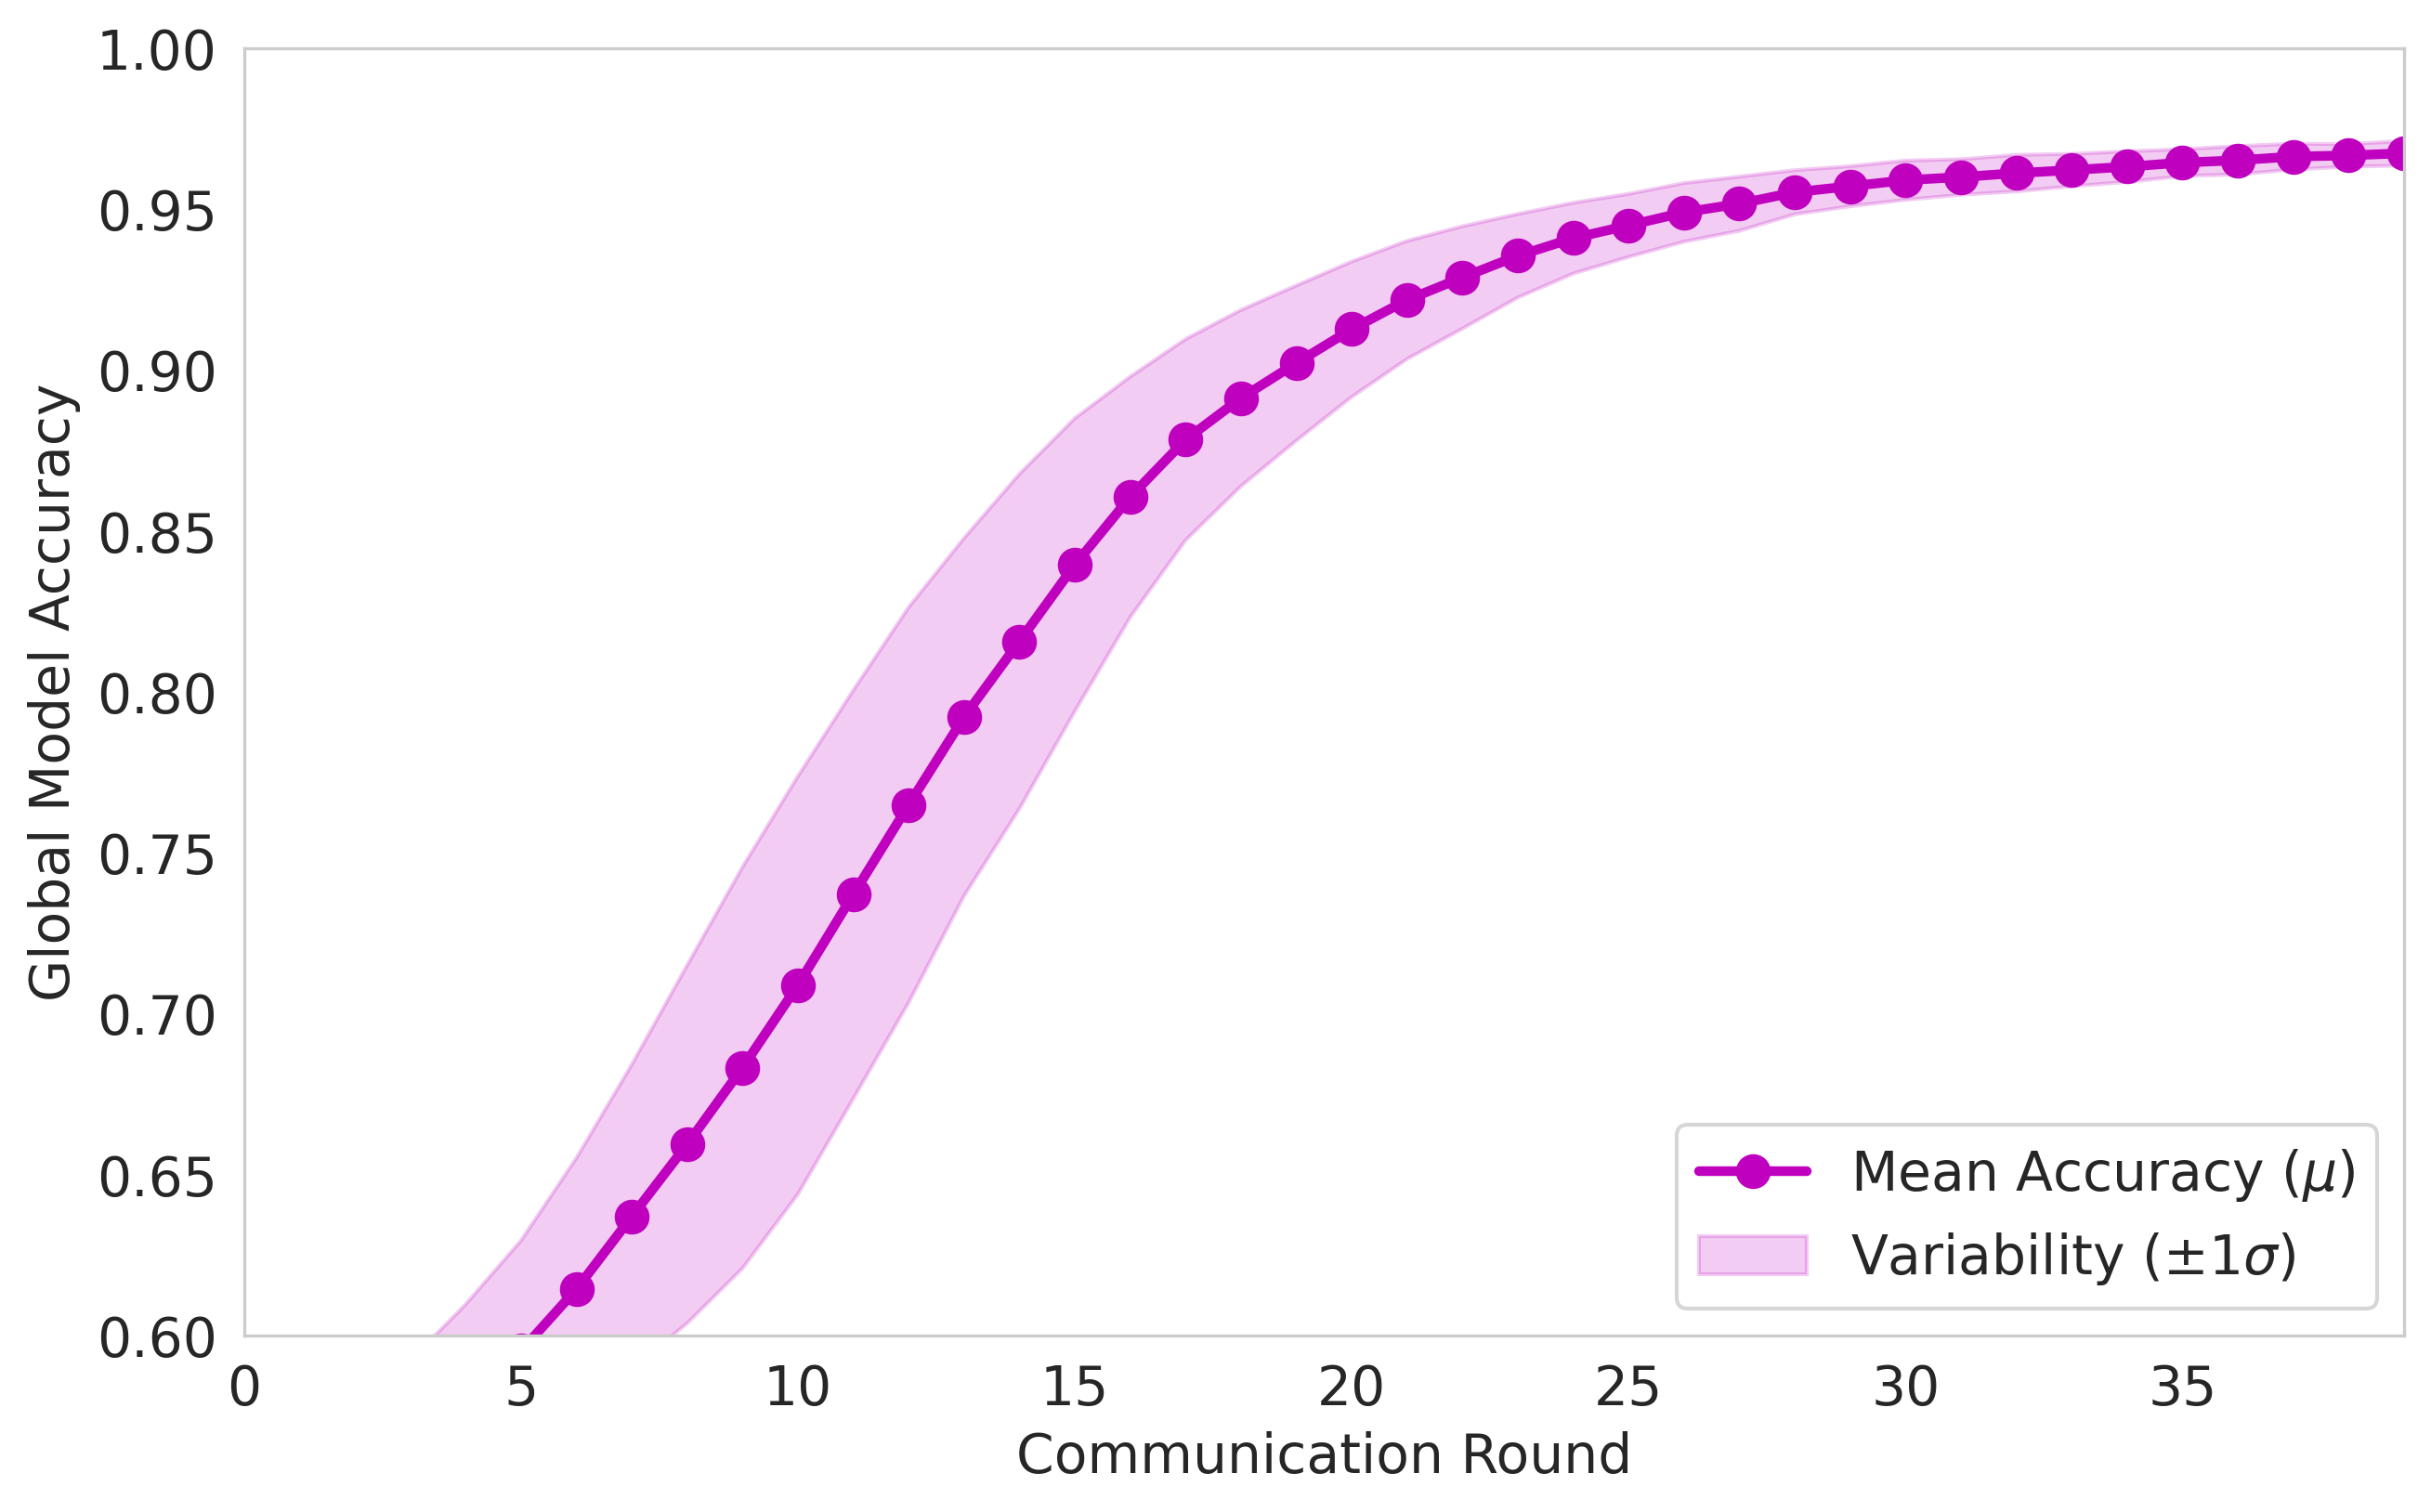


*** Log: Figure 1 Data (FL Convergence Curve) ***
 Round  Mean_Accuracy  Std_Dev
     0       0.374579 0.040925
     2       0.532437 0.039454
     4       0.580513 0.029243
     6       0.614433 0.040794
     8       0.659492 0.055647
    10       0.708926 0.064956
    12       0.764948 0.061418
    14       0.815766 0.052018
    16       0.860624 0.037386
    18       0.891350 0.027390
    20       0.912748 0.021036
    22       0.928841 0.015901
    24       0.941036 0.011002
    26       0.949057 0.009114
    28       0.955318 0.006855
    30       0.959065 0.006089
    32       0.961252 0.005674
    34       0.963264 0.004758
    36       0.965250 0.004385
    38       0.966759 0.003507
------------------------------------------------------------


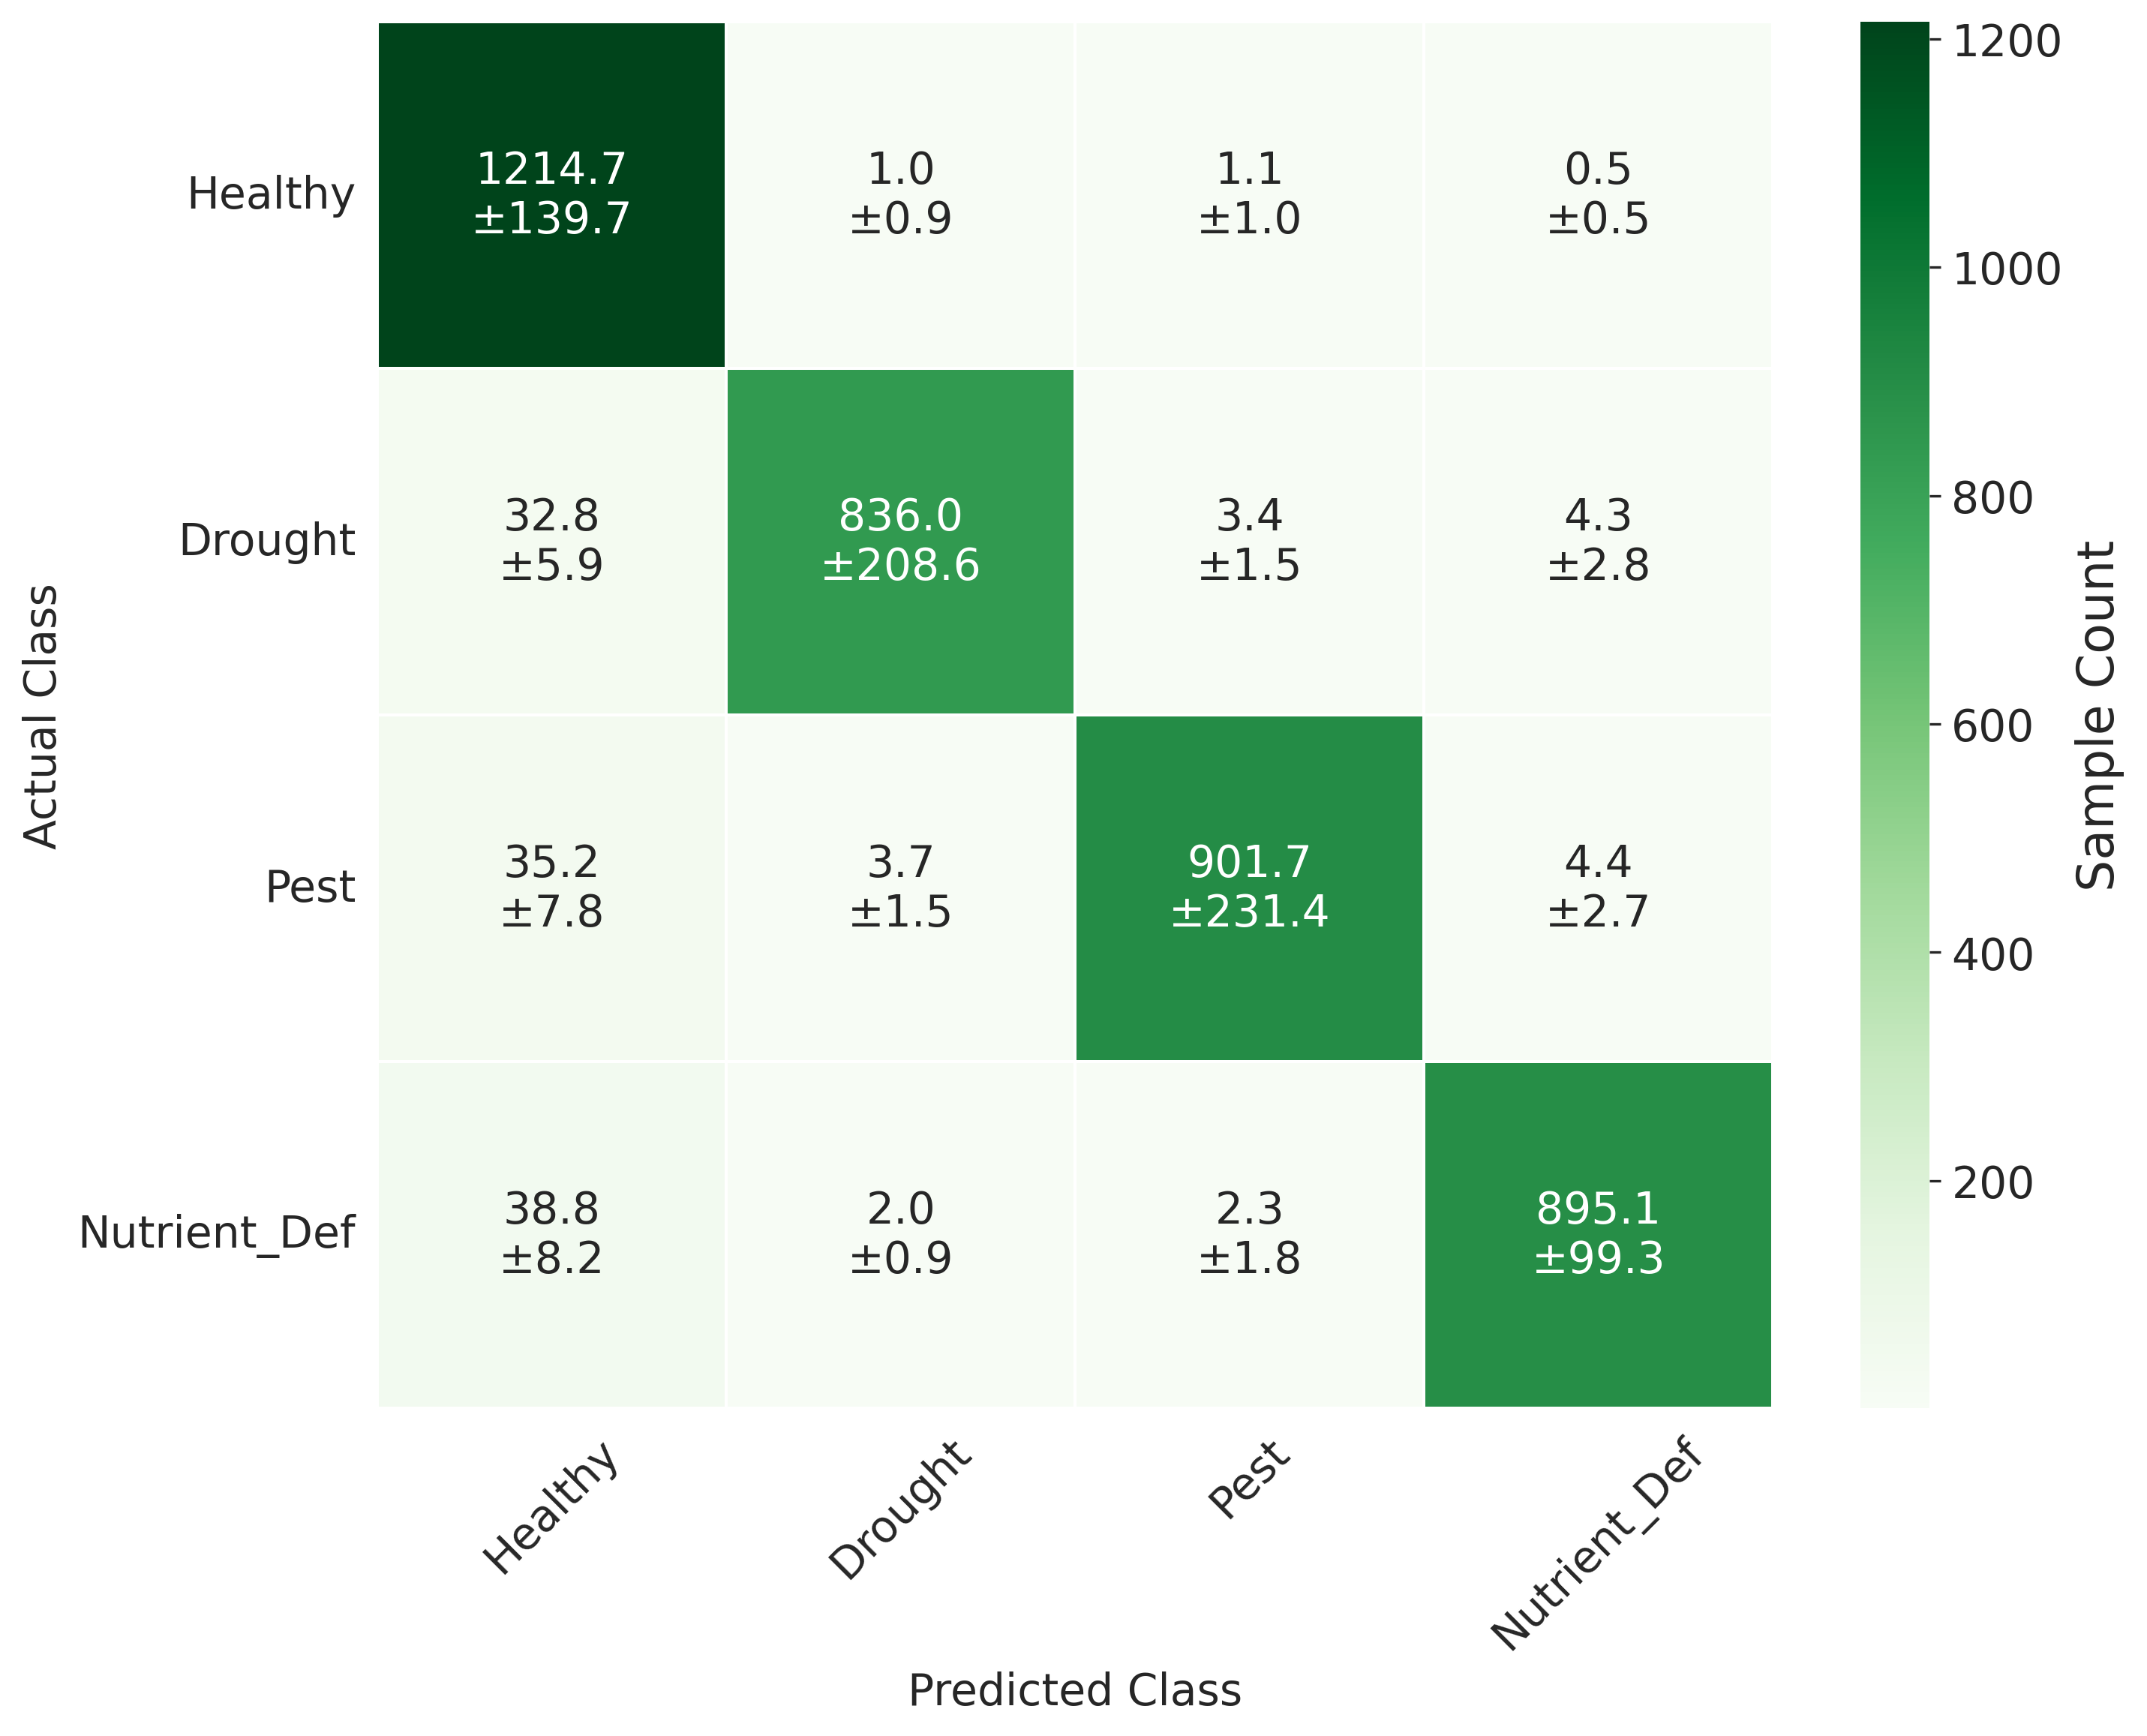


*** Log: Figure 2 Data (Confusion Matrix Mean ± SD) ***
|              | Healthy        | Drought       | Pest          | Nutrient_Def   |
|:-------------|:---------------|:--------------|:--------------|:---------------|
| Healthy      | 1214.7 ± 139.7 | 1.0 ± 0.9     | 1.1 ± 1.0     | 0.5 ± 0.5      |
| Drought      | 32.8 ± 5.9     | 836.0 ± 208.6 | 3.4 ± 1.5     | 4.3 ± 2.8      |
| Pest         | 35.2 ± 7.8     | 3.7 ± 1.5     | 901.7 ± 231.4 | 4.4 ± 2.7      |
| Nutrient_Def | 38.8 ± 8.2     | 2.0 ± 0.9     | 2.3 ± 1.8     | 895.1 ± 99.3   |
------------------------------------------------------------


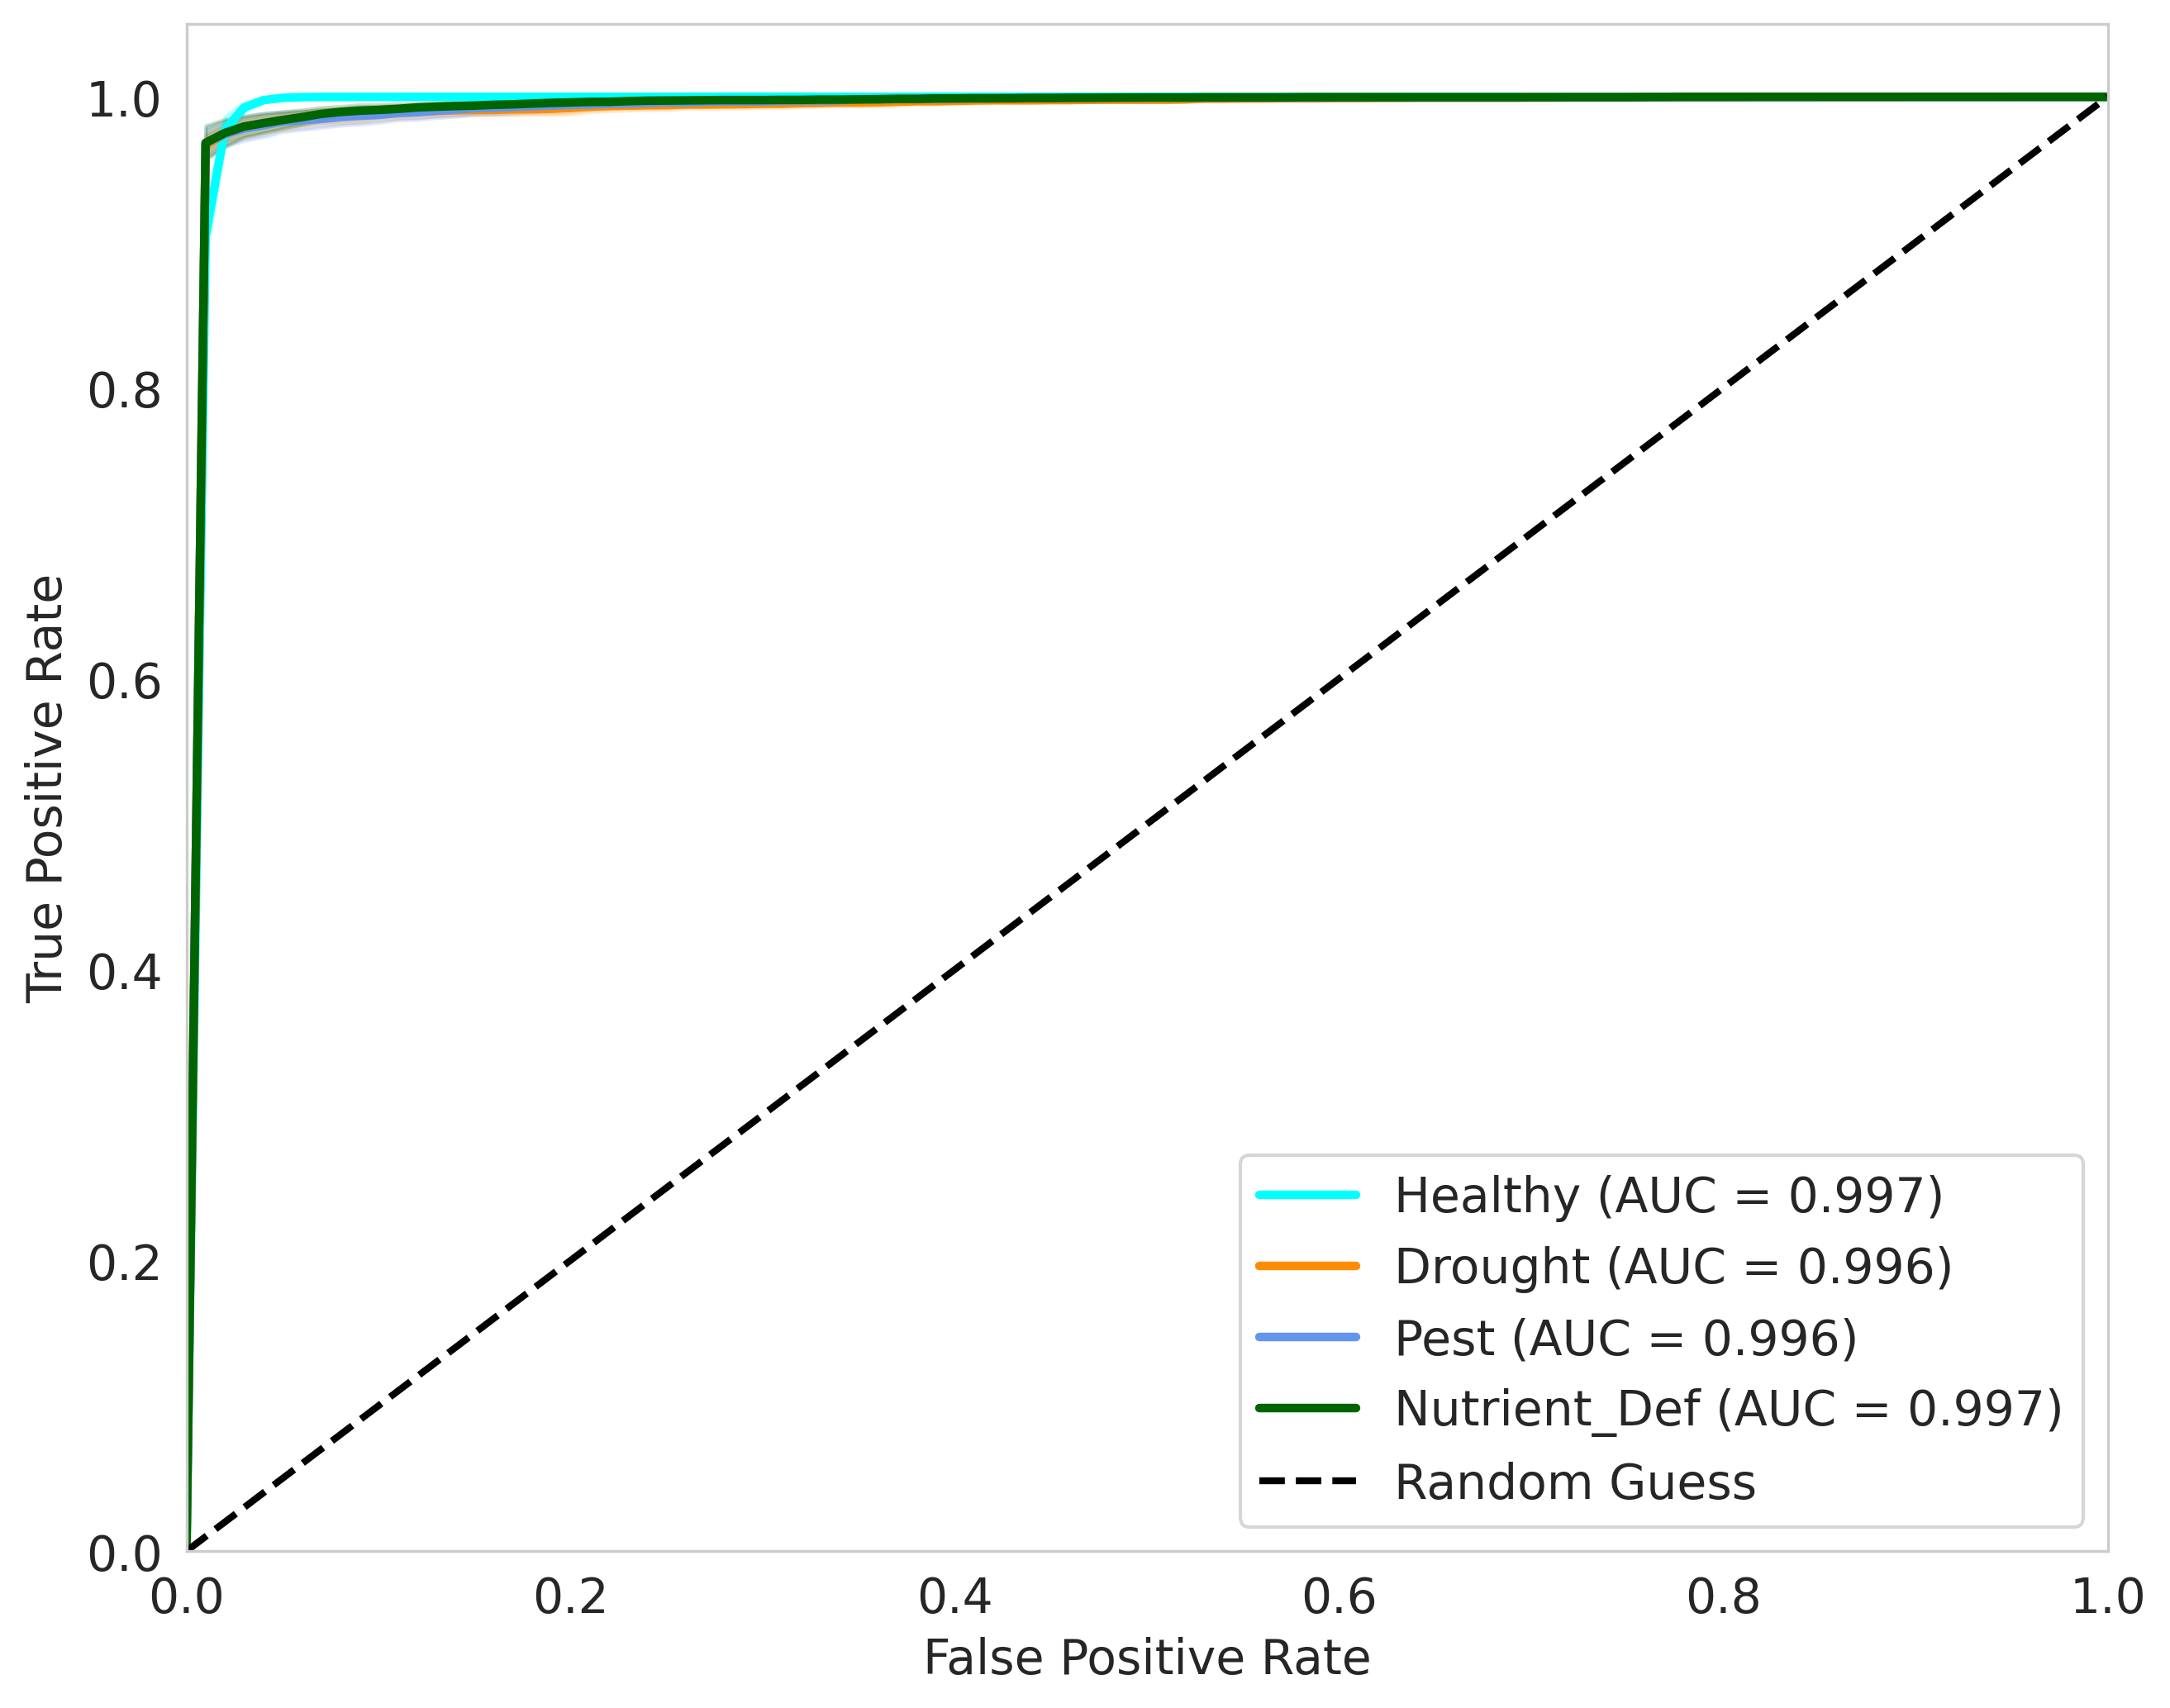


*** Log: Figure 3 Data (ROC Curve Points) ***
 False_Positive_Rate  TPR_Healthy  TPR_Drought  TPR_Pest  TPR_Nutrient_Def
                0.00     0.000000     0.000000  0.000000          0.000000
                0.05     0.999274     0.983240  0.982967          0.984058
                0.10     0.999925     0.988654  0.987560          0.990992
                0.15     1.000000     0.991062  0.992199          0.993972
                0.20     1.000000     0.992337  0.994419          0.996161
                0.25     1.000000     0.994288  0.996102          0.997429
                0.30     1.000000     0.995269  0.996838          0.997772
                0.35     1.000000     0.996076  0.998388          0.998210
                0.40     1.000000     0.997258  0.998797          0.998888
                0.45     1.000000     0.997817  0.999200          0.999196
                0.50     1.000000     0.998050  0.999448          0.999521
                0.55     1.000000     0.998858  0.999

In [7]:
# CELL 7
# ==============================================================================
# VISUALIZATION: Federated Learning Convergence, Confusion Matrix, ROC
# ==============================================================================
import os
# Ensure output folder exists before plotting
output_folder = "QAL_Simulation_Artifacts"
os.makedirs(output_folder, exist_ok=True)

print(f"Generating Performance Figures. Saving to: {output_folder}")

# --- Plot 1: Federated Learning Convergence ---
mean_accuracy = np.mean([h['accuracy'] for h in all_histories], axis=0)
std_accuracy = np.std([h['accuracy'] for h in all_histories], axis=0)
rounds = np.arange(CONFIG.FL_ROUNDS)

plt.figure(figsize=(10, 6))
# SCIENTIFIC LABELING: Standard statistical notation
plt.plot(rounds, mean_accuracy, 'm-o', label=r'Mean Accuracy ($\mu$)', linewidth=2.5)
plt.fill_between(rounds, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy,
                 color='m', alpha=0.2, label=r'Variability ($\pm 1\sigma$)')

# FORCE X-AXIS TO 0
plt.xlim(0, CONFIG.FL_ROUNDS - 1)
plt.ylim(0.6, 1.0)
plt.xlabel('Communication Round', fontsize=14)
plt.ylabel('Global Model Accuracy', fontsize=14)
plt.legend(loc='lower right', frameon=True)
plt.grid(False)
plt.savefig(os.path.join(output_folder, 'federated_learning_convergence.png'))
plt.show()

# TEXT DUMP
print("\n*** Log: Figure 1 Data (FL Convergence Curve) ***")
conv_dump = pd.DataFrame({'Round': rounds, 'Mean_Accuracy': mean_accuracy, 'Std_Dev': std_accuracy})
print(conv_dump.iloc[::2].to_string(index=False))
print("-" * 60)


# --- Plot 2: Mean Confusion Matrix ---
mean_cm = np.mean(all_confusion_matrices, axis=0)
std_cm = np.std(all_confusion_matrices, axis=0)
annot_labels = np.empty_like(mean_cm, dtype=object)
for i in range(mean_cm.shape[0]):
    for j in range(mean_cm.shape[1]):
        annot_labels[i, j] = f"{mean_cm[i, j]:.1f}\n±{std_cm[i, j]:.1f}"

plt.figure(figsize=(10, 8))
sns.heatmap(mean_cm, annot=annot_labels, fmt='', cmap='Greens',
            xticklabels=CONFIG.STRESS_CLASSES, yticklabels=CONFIG.STRESS_CLASSES,
            linewidths=0.5, linecolor='white', cbar_kws={'label': 'Sample Count'})
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('Actual Class', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.savefig(os.path.join(output_folder, 'mean_confusion_matrix.png'))
plt.show()

# TEXT DUMP
print("\n*** Log: Figure 2 Data (Confusion Matrix Mean ± SD) ***")
cm_rows = []
for i, row_label in enumerate(CONFIG.STRESS_CLASSES):
    row_data = {}
    for j, col_label in enumerate(CONFIG.STRESS_CLASSES):
        row_data[col_label] = f"{mean_cm[i, j]:.1f} ± {std_cm[i, j]:.1f}"
    cm_rows.append(row_data)
print(pd.DataFrame(cm_rows, index=CONFIG.STRESS_CLASSES).to_markdown())
print("-" * 60)


# --- Plot 3: Averaged ROC Curves ---
plt.figure(figsize=(10, 8))
base_fpr = np.linspace(0, 1, 101)
tprs_by_class = {i: [] for i in range(len(CONFIG.STRESS_CLASSES))}
aucs_by_class = {i: [] for i in range(len(CONFIG.STRESS_CLASSES))}

for run_data in all_roc_data:
    y_true, y_pred = run_data['true'], run_data['pred']
    for i in range(len(CONFIG.STRESS_CLASSES)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        tpr_interp = np.interp(base_fpr, fpr, tpr); tpr_interp[0] = 0.0
        tprs_by_class[i].append(tpr_interp)
        aucs_by_class[i].append(auc(fpr, tpr))

colors = ['aqua', 'darkorange', 'cornflowerblue', 'darkgreen']
roc_dump_dict = {'False_Positive_Rate': base_fpr}

for i, (class_name, color) in enumerate(zip(CONFIG.STRESS_CLASSES, colors)):
    mean_tprs = np.mean(tprs_by_class[i], axis=0)
    std_tprs = np.std(tprs_by_class[i], axis=0)
    mean_auc = np.mean(aucs_by_class[i])
    roc_dump_dict[f'TPR_{class_name}'] = mean_tprs

    plt.plot(base_fpr, mean_tprs, color=color, lw=2.5, label=f'{class_name} (AUC = {mean_auc:.3f})')
    plt.fill_between(base_fpr, np.maximum(0.0, mean_tprs - std_tprs), np.minimum(1.0, mean_tprs + std_tprs), color=color, alpha=0.2)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.legend(loc="lower right", frameon=True)
plt.grid(False)
plt.savefig(os.path.join(output_folder, 'mean_roc_curves.png'))
plt.show()

# TEXT DUMP
print("\n*** Log: Figure 3 Data (ROC Curve Points) ***")
print(pd.DataFrame(roc_dump_dict).iloc[::5].to_string(index=False))
print("-" * 60)

### **CELL 8: Comparative Ablation Study**

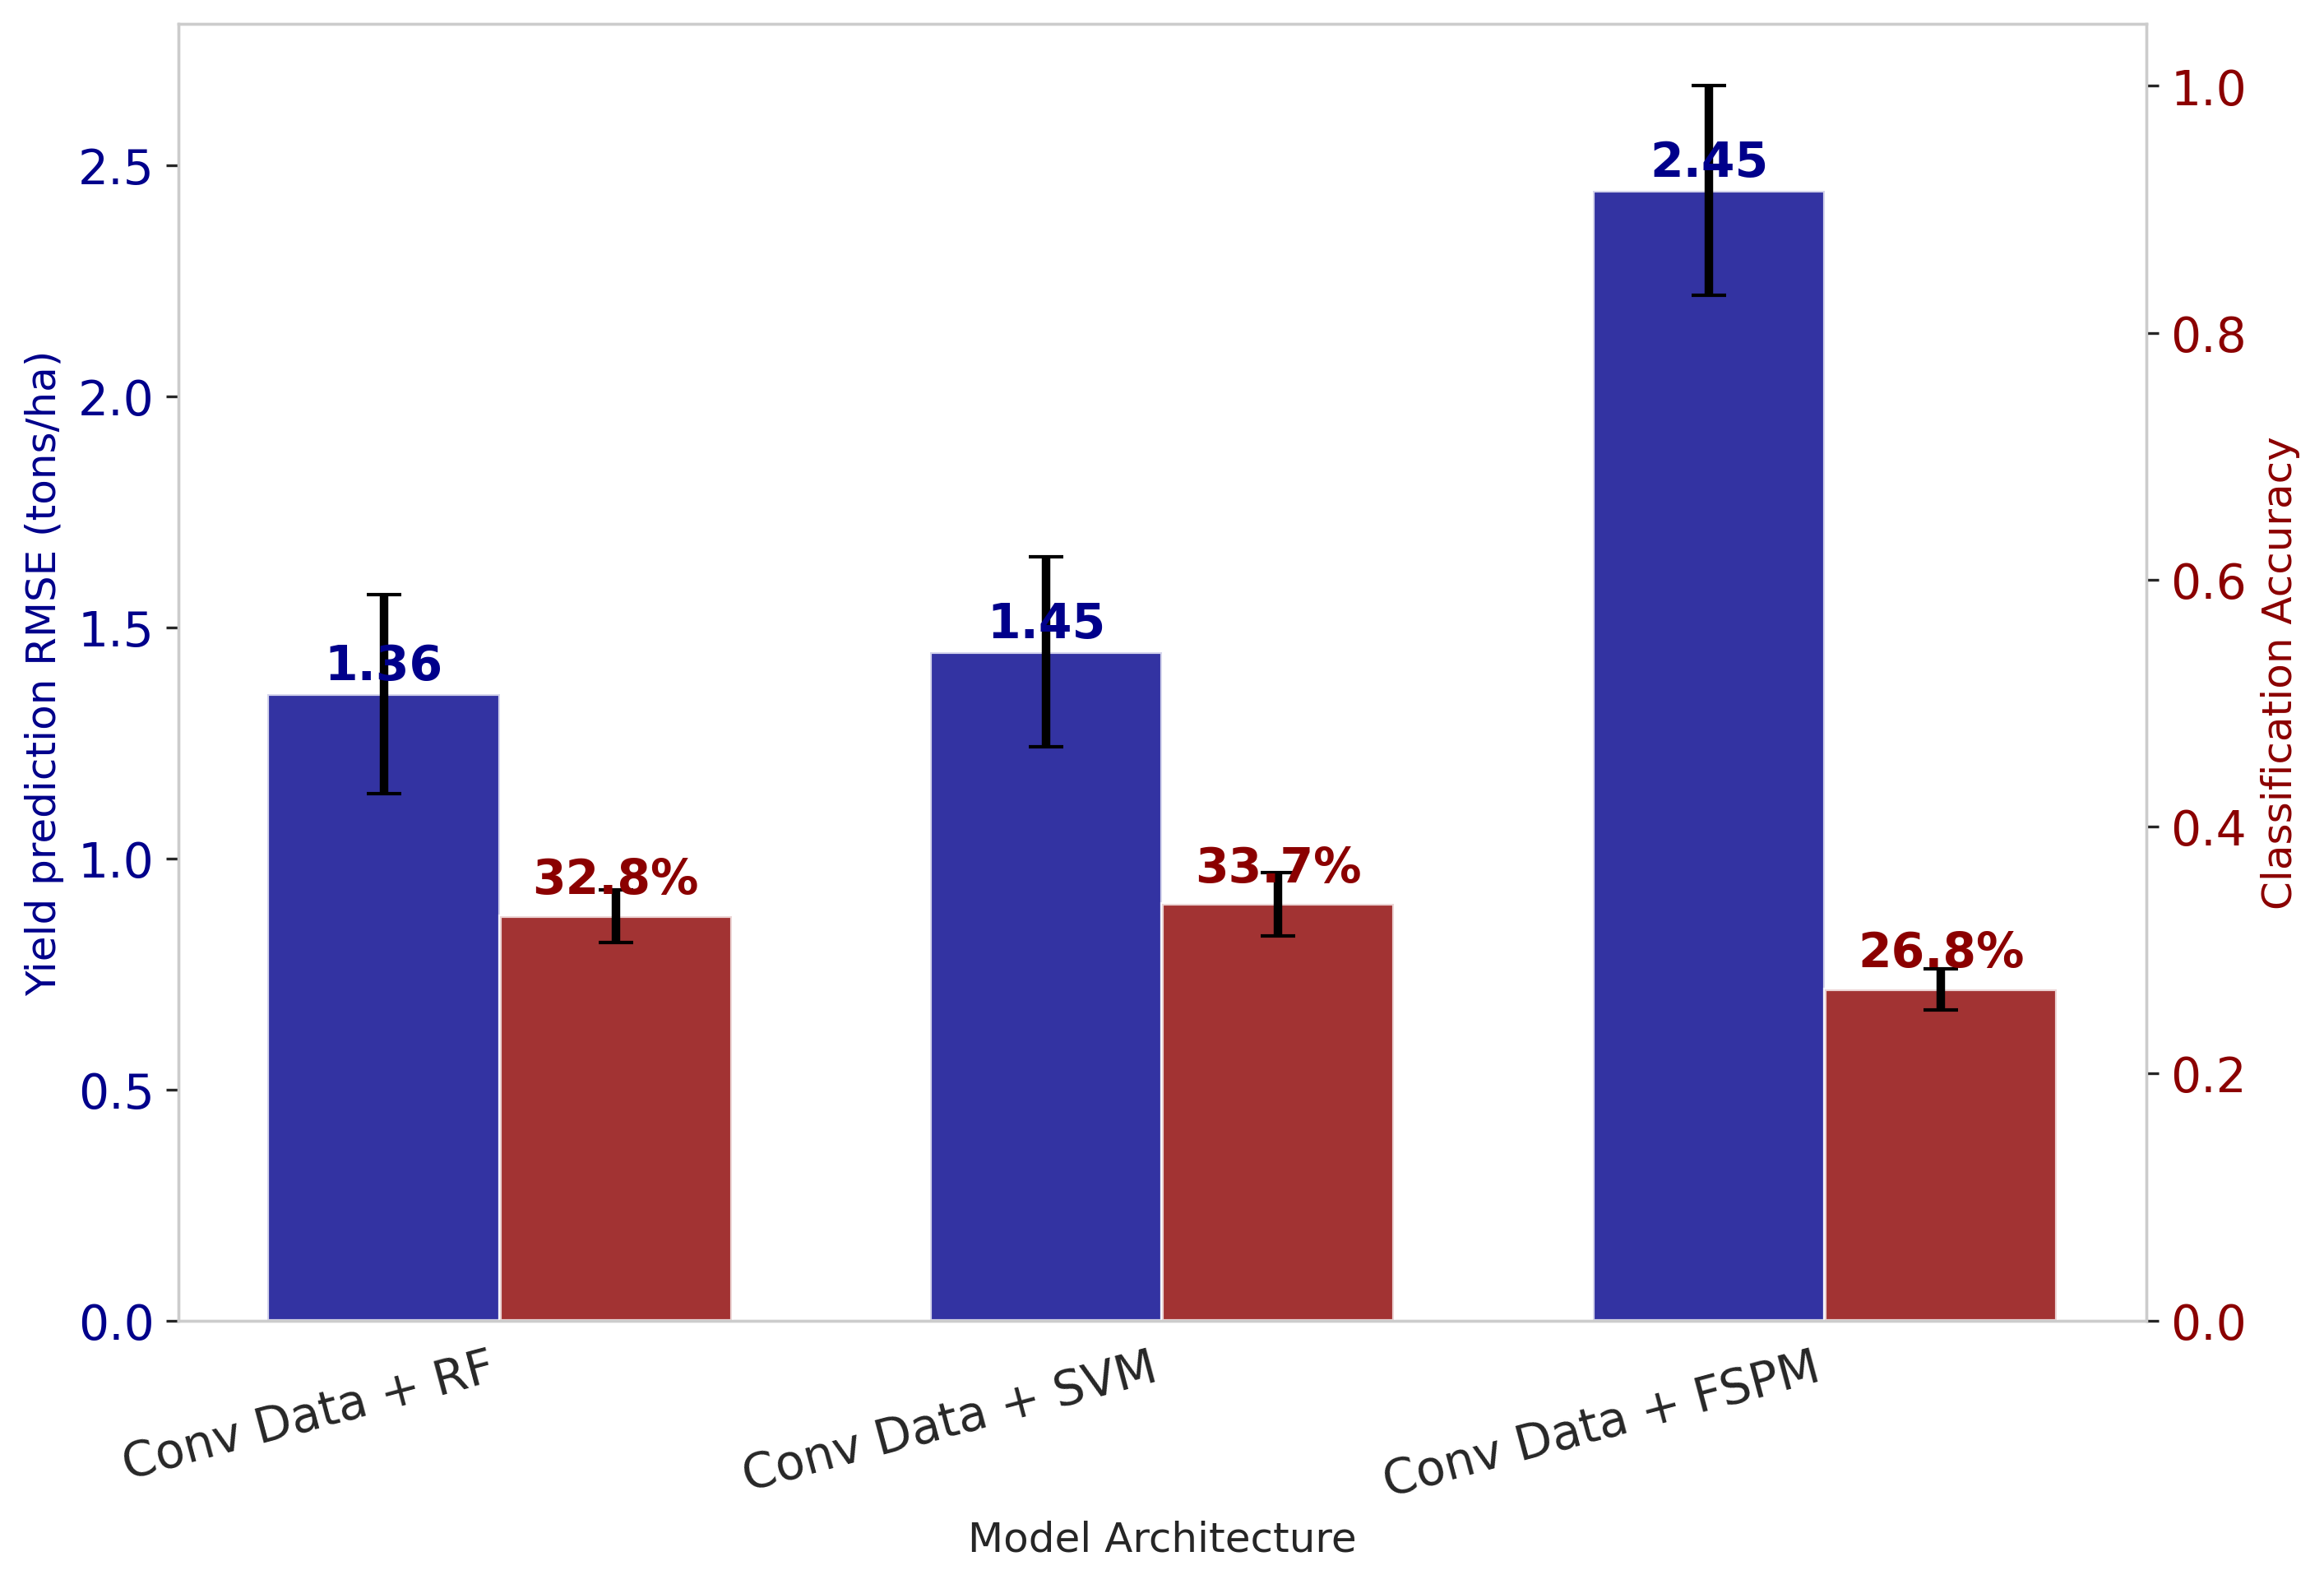

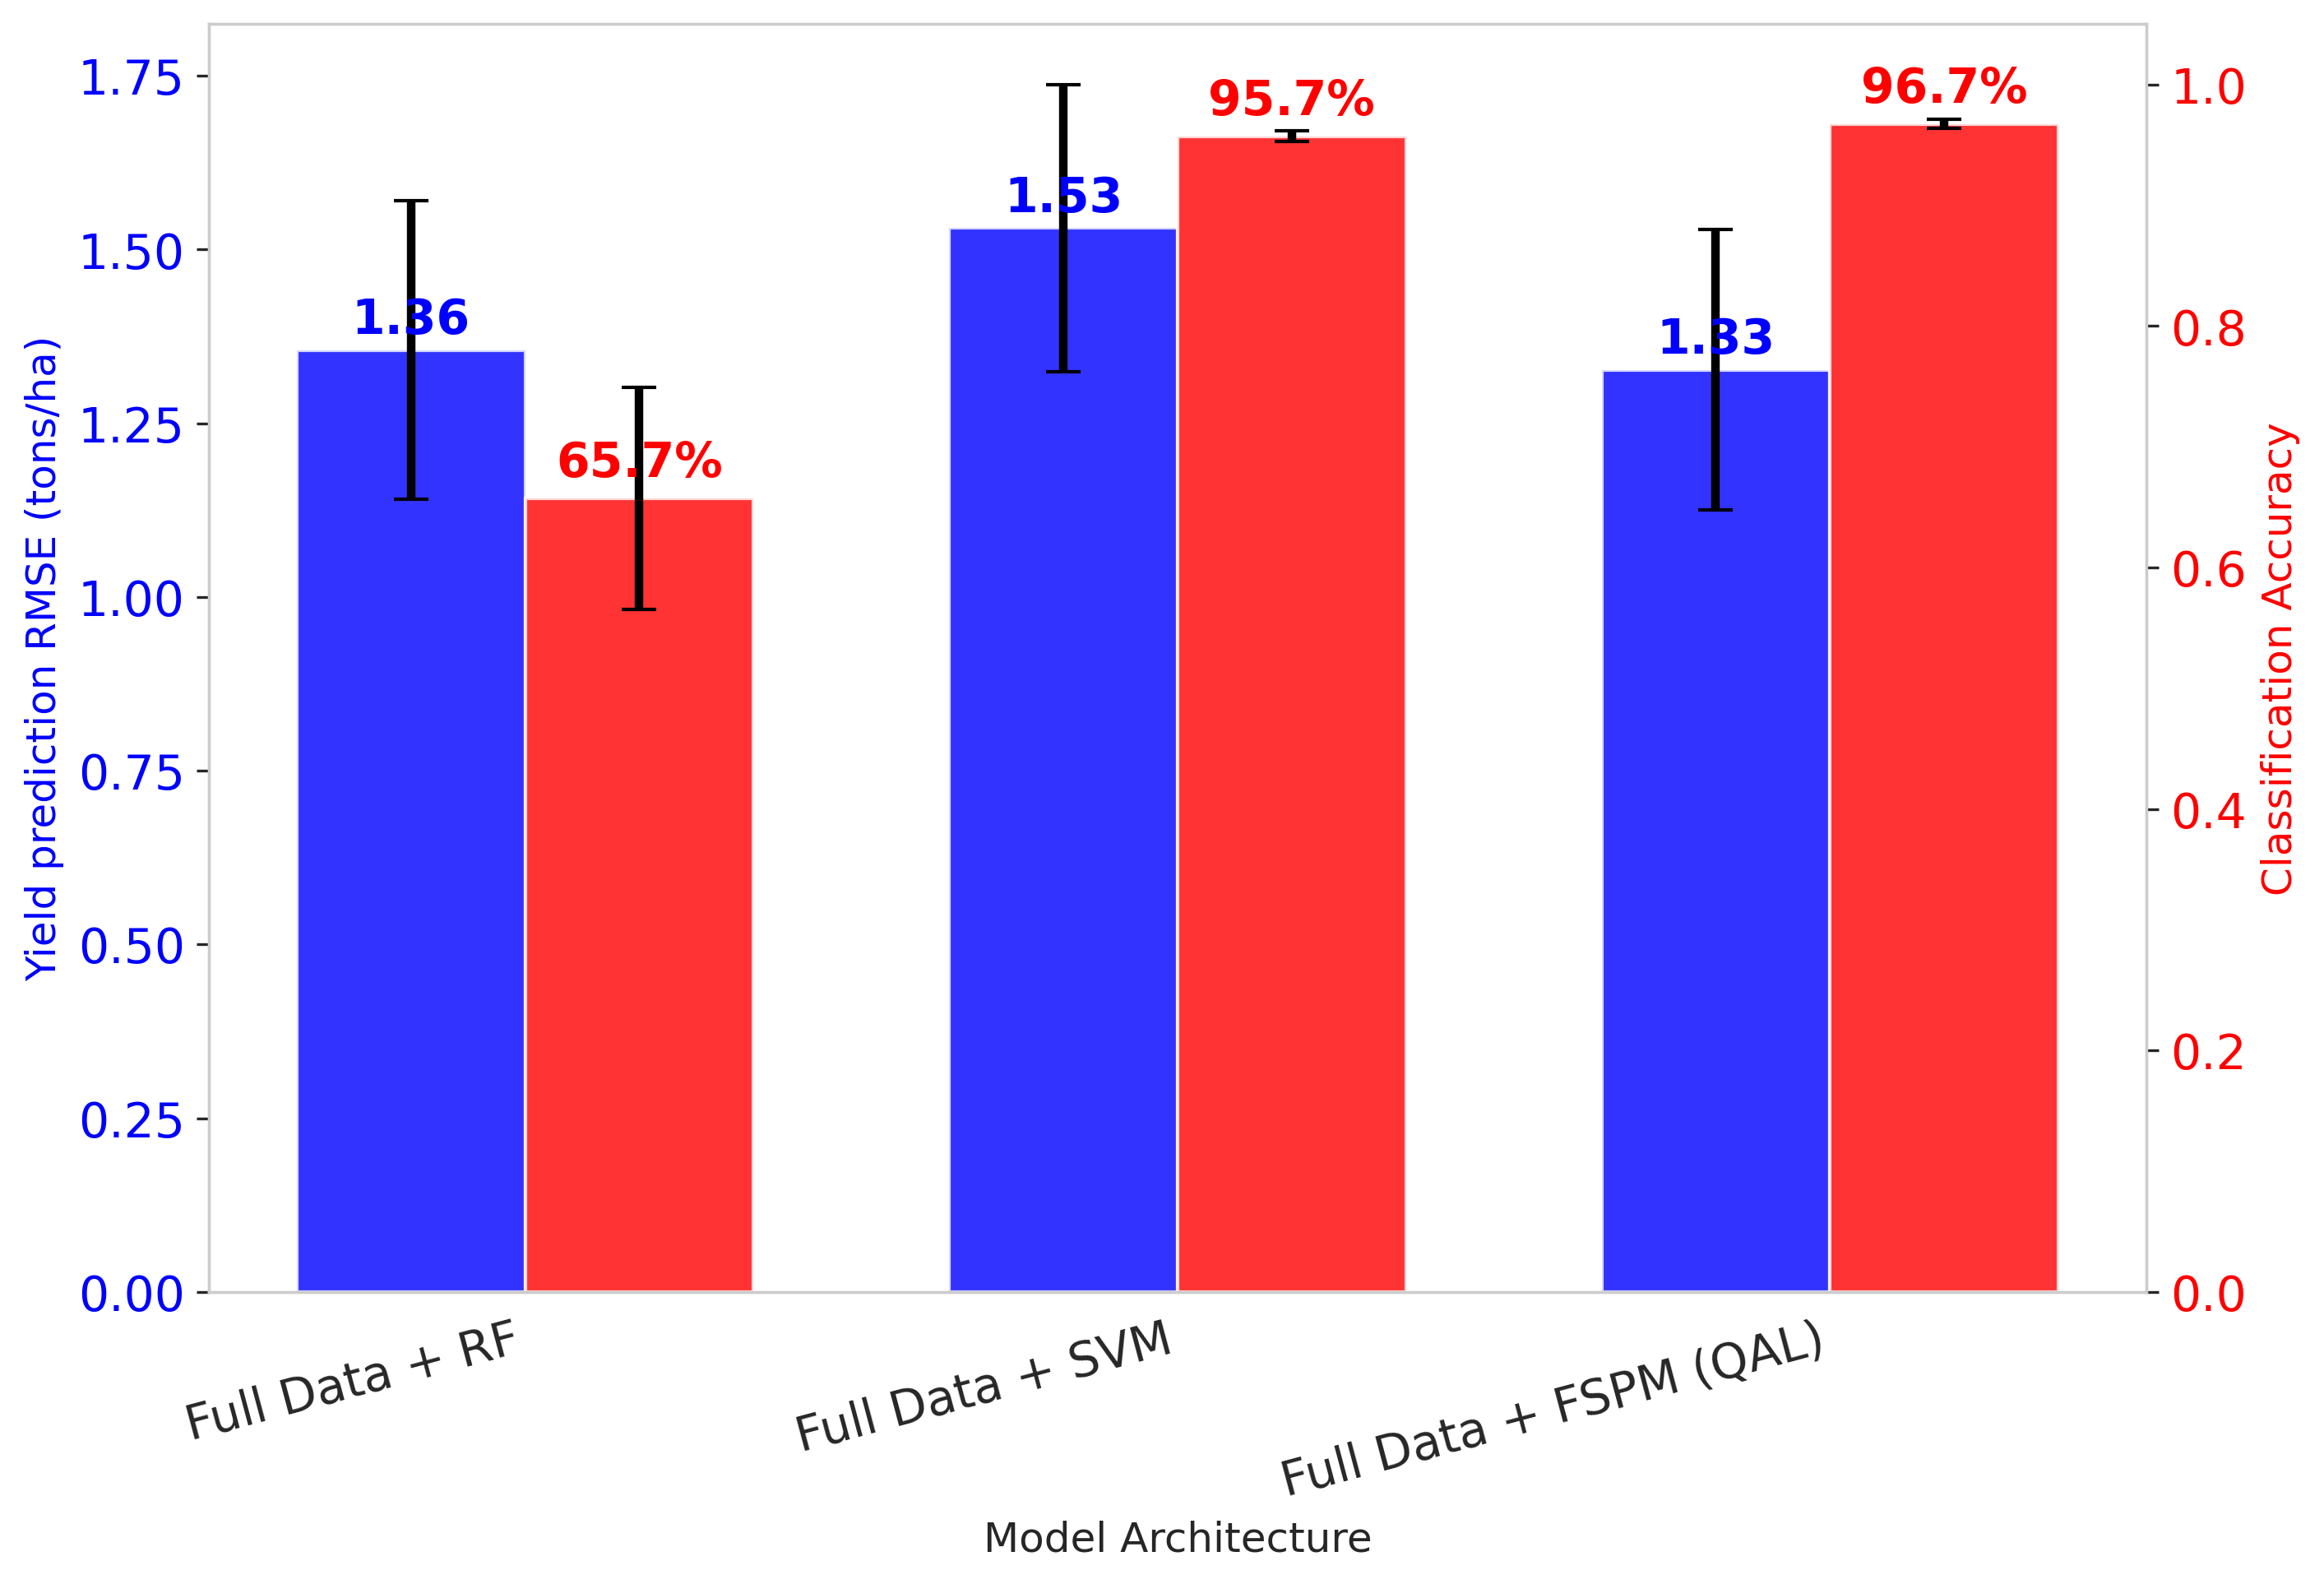


*** Log: Ablation Study Summary Table ***
                            rmse            accuracy          
                            mean       std      mean       std
model                                                         
Conv Data + RF          1.355100  0.214637  0.327533  0.021409
Conv Data + SVM         1.446219  0.205582  0.337189  0.025753
Conv Data + FSPM        2.445078  0.226395  0.268343  0.016653
Full Data + RF          1.355100  0.214637  0.657103  0.091791
Full Data + SVM         1.530633  0.206802  0.957053  0.004347
Full Data + FSPM (QAL)  1.326892  0.201615  0.967438  0.004008
------------------------------------------------------------


In [8]:
# CELL 8
# ==============================================================================
# VISUALIZATION: Comparative Ablation Study (Conventional vs. Full QAL)
# ==============================================================================
# Convert the list of results into a pandas DataFrame
ablation_df = pd.DataFrame(all_ablation_results)
ablation_summary = ablation_df.groupby('model').agg(['mean', 'std'])
model_order = ['Conv Data + RF', 'Conv Data + SVM', 'Conv Data + FSPM',
               'Full Data + RF', 'Full Data + SVM', 'Full Data + FSPM (QAL)']
ablation_summary = ablation_summary.reindex(model_order)

group1_summary = ablation_summary.loc[['Conv Data + RF', 'Conv Data + SVM', 'Conv Data + FSPM']]
group2_summary = ablation_summary.loc[['Full Data + RF', 'Full Data + SVM', 'Full Data + FSPM (QAL)']]

# --- Plot 1 (Conventional Data Models) ---
fig, ax1 = plt.subplots(figsize=(10, 7))
x_labels_g1 = group1_summary.index; x_g1 = np.arange(len(x_labels_g1)); width = 0.35
rects1_g1 = ax1.bar(x_g1 - width/2, group1_summary[('rmse', 'mean')], width,
                    yerr=group1_summary[('rmse', 'std')], capsize=5,
                    label='Yield RMSE', color='darkblue', alpha=0.8)

# TWEAK: "Model Architecture" is more scientific than "Configuration"
ax1.set_xlabel('Model Architecture', fontsize=12)
ax1.set_ylabel('Yield prediction RMSE (tons/ha)', color='darkblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='darkblue')

ax2_g1 = ax1.twinx()
rects2_g1 = ax2_g1.bar(x_g1 + width/2, group1_summary[('accuracy', 'mean')], width,
                       yerr=group1_summary[('accuracy', 'std')], capsize=5,
                       label='Classification Accuracy', color='darkred', alpha=0.8)
ax2_g1.set_ylabel('Classification Accuracy', color='darkred', fontsize=12)
ax2_g1.tick_params(axis='y', labelcolor='darkred')
ax2_g1.set_ylim(0, 1.05)

ax1.set_xticks(x_g1)
ax1.set_xticklabels(x_labels_g1, rotation=15, ha="right")
fig.tight_layout(pad=2)

for bar in rects1_g1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', color='darkblue', fontweight='bold')
for bar in rects2_g1:
    yval = bar.get_height()
    ax2_g1.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.1%}', ha='center', va='bottom', color='darkred', fontweight='bold')

ax1.grid(False)
ax2_g1.grid(False)
plt.savefig(os.path.join(output_folder, 'ablation_conventional_data.png'))
plt.show()


# --- Plot 2 (Full Data Models) ---
fig, ax1 = plt.subplots(figsize=(10, 7))
x_labels_g2 = group2_summary.index; x_g2 = np.arange(len(x_labels_g2))

rects1_g2 = ax1.bar(x_g2 - width/2, group2_summary[('rmse', 'mean')], width,
                    yerr=group2_summary[('rmse', 'std')], capsize=5,
                    label='Yield RMSE', color='blue', alpha=0.8)

# TWEAK: "Model Architecture"
ax1.set_xlabel('Model Architecture', fontsize=12)
ax1.set_ylabel('Yield prediction RMSE (tons/ha)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

ax2_g2 = ax1.twinx()
rects2_g2 = ax2_g2.bar(x_g2 + width/2, group2_summary[('accuracy', 'mean')], width,
                       yerr=group2_summary[('accuracy', 'std')], capsize=5,
                       label='Classification Accuracy', color='red', alpha=0.8)
ax2_g2.set_ylabel('Classification Accuracy', color='red', fontsize=12)
ax2_g2.tick_params(axis='y', labelcolor='red')
ax2_g2.set_ylim(0, 1.05)

ax1.set_xticks(x_g2)
ax1.set_xticklabels(x_labels_g2, rotation=15, ha="right")
fig.tight_layout(pad=2)

for bar in rects1_g2:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', color='blue', fontweight='bold')
for bar in rects2_g2:
    yval = bar.get_height()
    ax2_g2.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.1%}', ha='center', va='bottom', color='red', fontweight='bold')

ax1.grid(False)
ax2_g2.grid(False)
plt.savefig(os.path.join(output_folder, 'ablation_full_data.png'))
plt.show()

# TEXT DUMP
print("\n*** Log: Ablation Study Summary Table ***")
print(ablation_summary[['rmse', 'accuracy']].to_string())
print("-" * 60)

### **CELL 9: Nutrient Simulation**

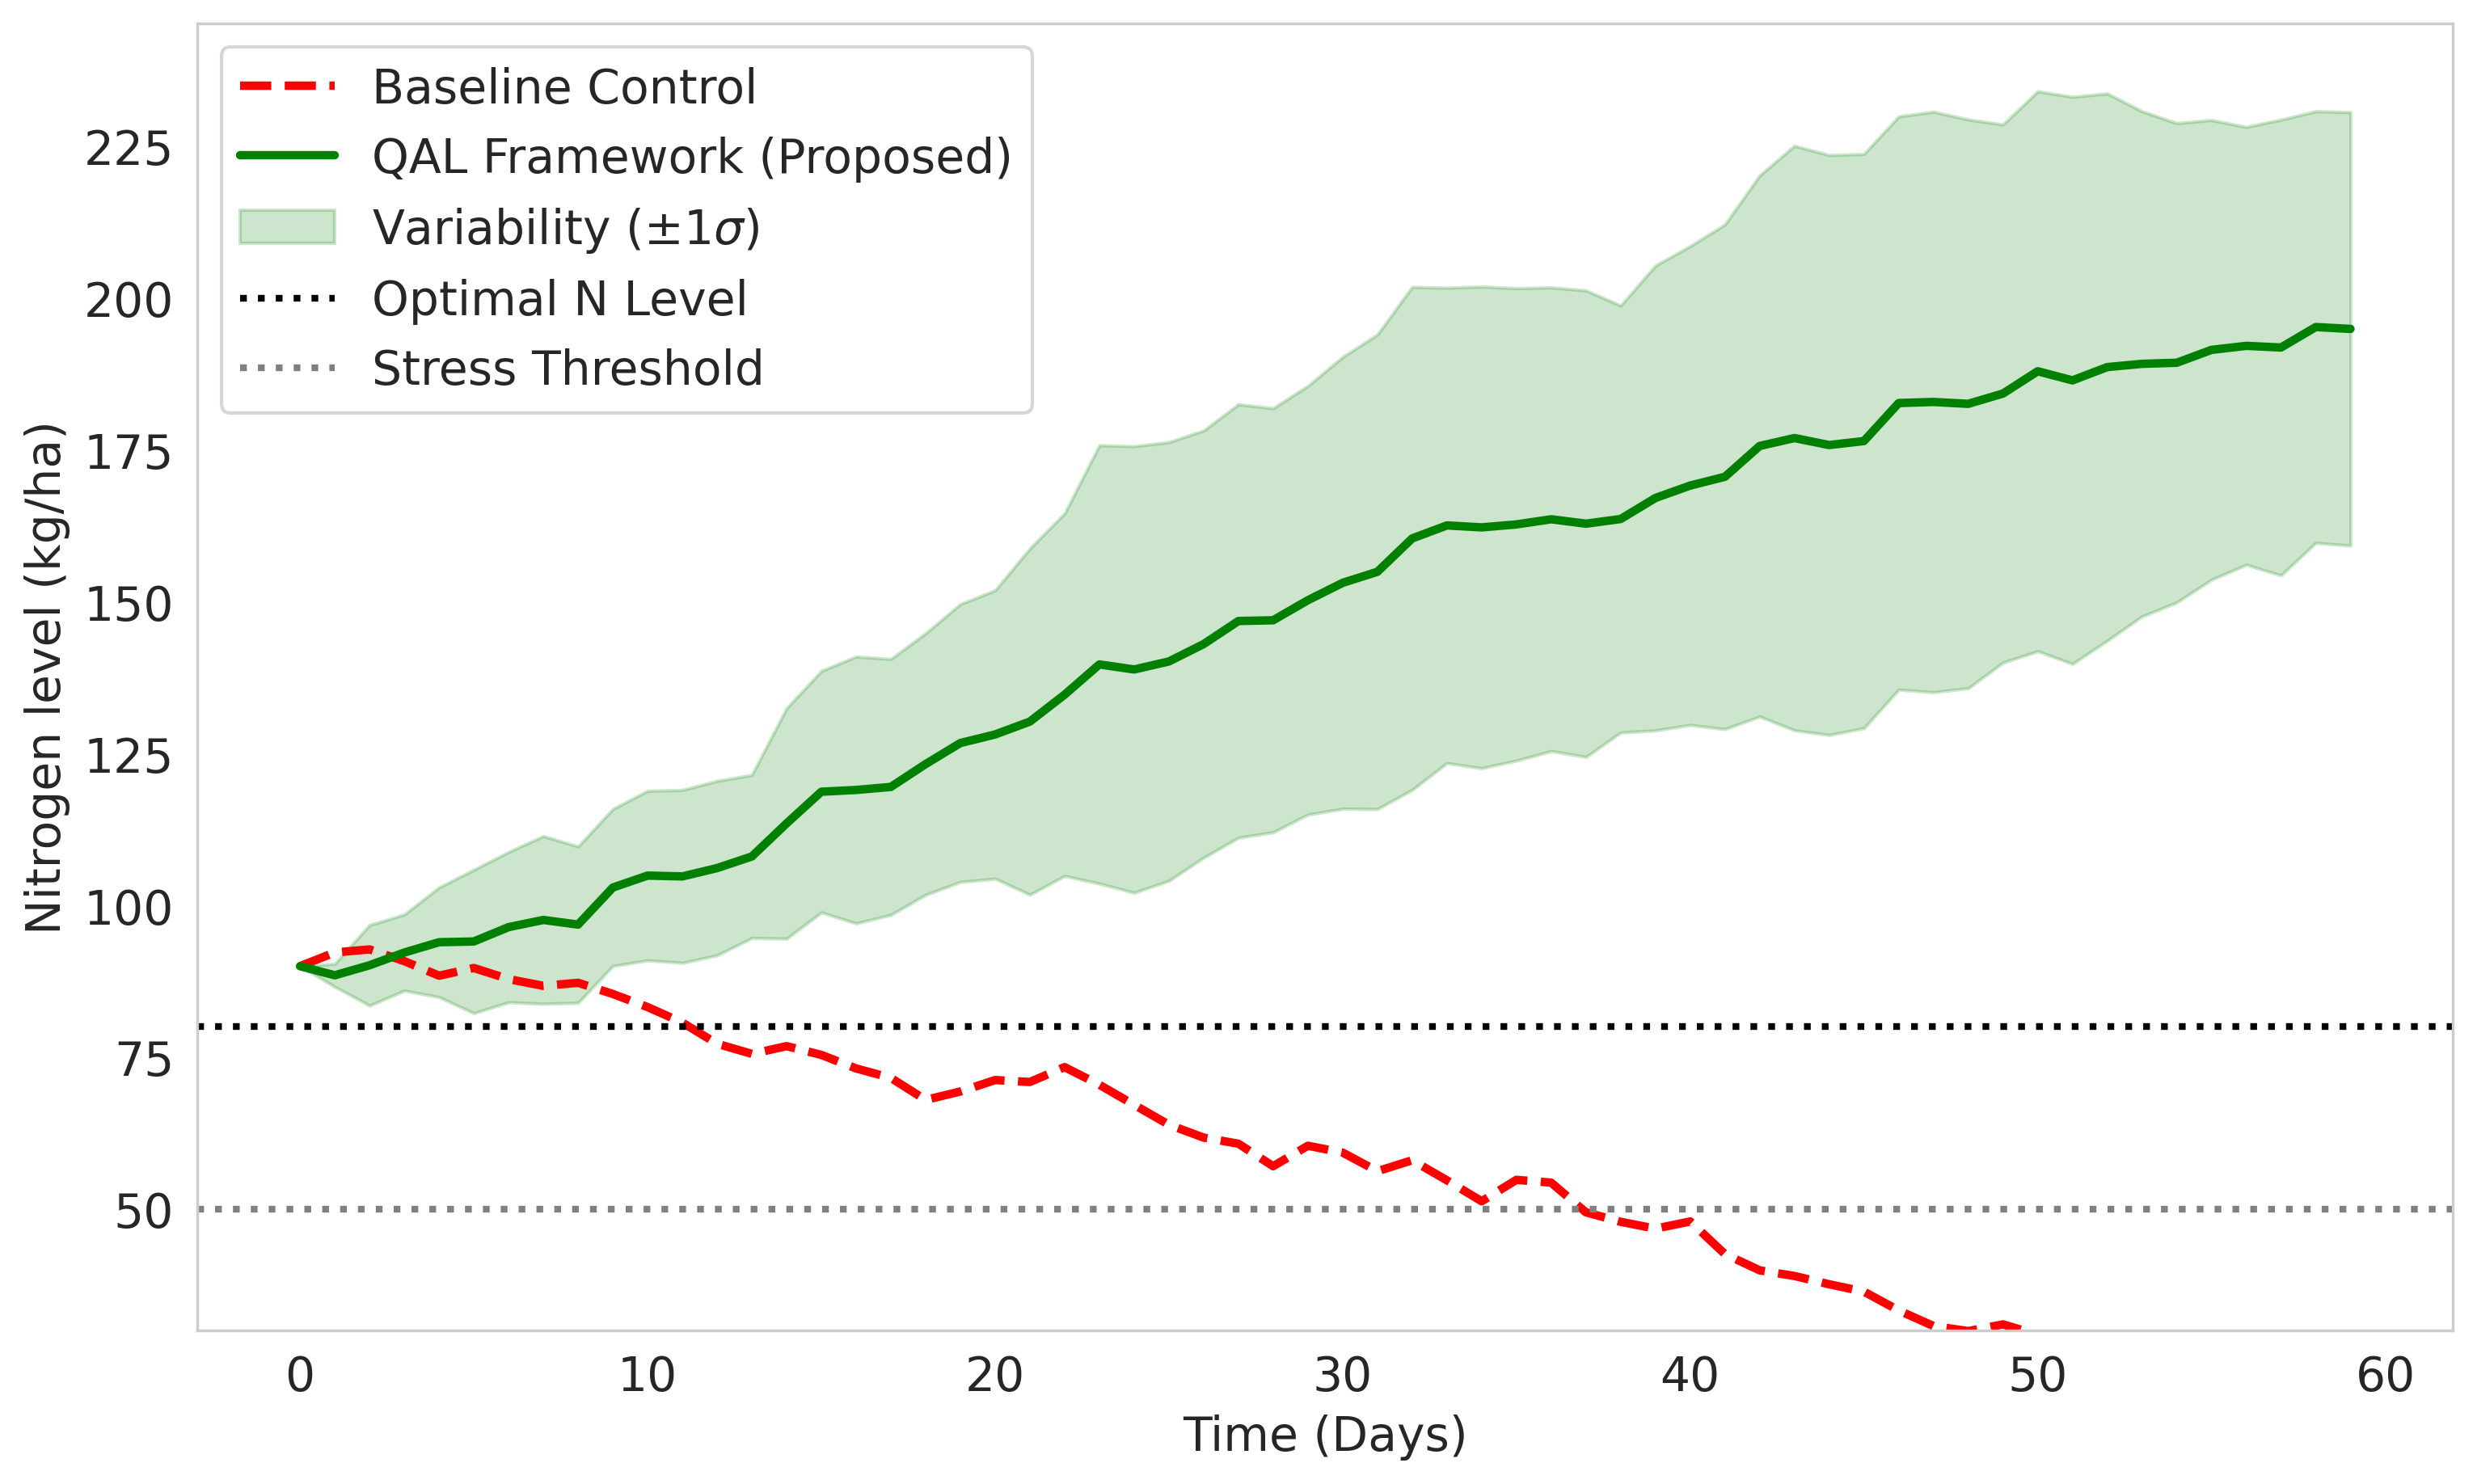


*** Log: Nutrient Simulation Data ***
 Day  N_Level_Baseline  N_Level_QAL
   0         90.000000    90.000000
   2         92.760157    90.149270
   4         88.431245    93.944135
   6         87.869638    96.428787
   8         87.261827    96.845646
  10         83.263739   104.915635
  12         77.221696   106.150511
  14         76.831406   113.506732
  16         73.160046   119.014058
  18         67.976060   123.275529
  20         71.250338   128.151132
  22         73.377159   134.707082
  24         67.170620   138.853244
  26         61.774811   143.034272
  28         57.059482   146.957613
  30         59.306903   153.118007
  32         58.044005   160.428766
  34         51.291239   162.248231
  36         54.357408   163.585151
  38         47.906969   163.626483
  40         47.967530   169.134672
  42         39.918014   175.654511
  44         37.624819   175.806760
  46         33.310591   182.722447
  48         29.911796   182.590156
  50         29.321620   

In [9]:
# CELL 9
# ==============================================================================
# VISUALIZATION: Dynamic Nutrient Management Simulation
# ==============================================================================
# --- Data preparation for nutrient simulation ---
days = 60; optimal_n = 80; stress_threshold = 50; depletion_rate = 1.2
all_n_levels_with_qal = []
for run_data in all_roc_data:
    n_levels_with_qal = np.zeros(days)
    n_levels_with_qal[0] = 90
    nutrient_def_prob = run_data['pred'][:days, 3]
    for d in range(1, days):
        n_levels_with_qal[d] = n_levels_with_qal[d-1] - depletion_rate + np.random.normal(0, 2)
        if nutrient_def_prob[d-1] > 0.5 or n_levels_with_qal[d] < optimal_n - 10:
            n_levels_with_qal[d] += 15
    all_n_levels_with_qal.append(n_levels_with_qal)
n_levels_no_qal = np.zeros(days)
n_levels_no_qal[0] = 90
for d in range(1, days):
    n_levels_no_qal[d] = n_levels_no_qal[d-1] - depletion_rate + np.random.normal(0, 2)
mean_n_with_qal = np.mean(all_n_levels_with_qal, axis=0)
std_n_with_qal = np.std(all_n_levels_with_qal, axis=0)

# --- Plot: Dynamic Nutrient Simulation ---
plt.figure(figsize=(12, 7))
plt.plot(n_levels_no_qal, 'r--', label='Baseline Control', linewidth=2.5)
plt.plot(mean_n_with_qal, 'g-', label='QAL Framework (Proposed)', linewidth=2.5)
plt.fill_between(range(days), mean_n_with_qal - std_n_with_qal, mean_n_with_qal + std_n_with_qal,
                 color='g', alpha=0.2, label=r'Variability ($\pm 1\sigma$)')

plt.axhline(y=optimal_n, color='k', linestyle=':', label='Optimal N Level', linewidth=2)
plt.axhline(y=stress_threshold, color='grey', linestyle=':', label='Stress Threshold', linewidth=2)

# TWEAK: "Time (Days)" is better than "Days into season"
plt.xlabel('Time (Days)', fontsize=14)
plt.ylabel('Nitrogen level (kg/ha)', fontsize=14)
plt.legend(frameon=True)
plt.ylim(bottom=30)
plt.grid(False)
plt.savefig(os.path.join(output_folder, 'nutrient_management_simulation.png'))
plt.show()

# TEXT DUMP
print("\n*** Log: Nutrient Simulation Data ***")
nutrient_dump = pd.DataFrame({'Day': range(days), 'N_Level_Baseline': n_levels_no_qal, 'N_Level_QAL': mean_n_with_qal})
print(nutrient_dump.iloc[::2].to_string(index=False))
print("-" * 60)

### **CELL 10: Robustness Analysis**

Initiating Noise Sensitivity & Robustness Analysis (σ=[0.05-0.30])...
  Completed analysis for sigma = 0.00 (Baseline)


Noise Analysis Progress:   0%|          | 0/6 [00:00<?, ?it/s]


Analysis complete. Generating final plot...


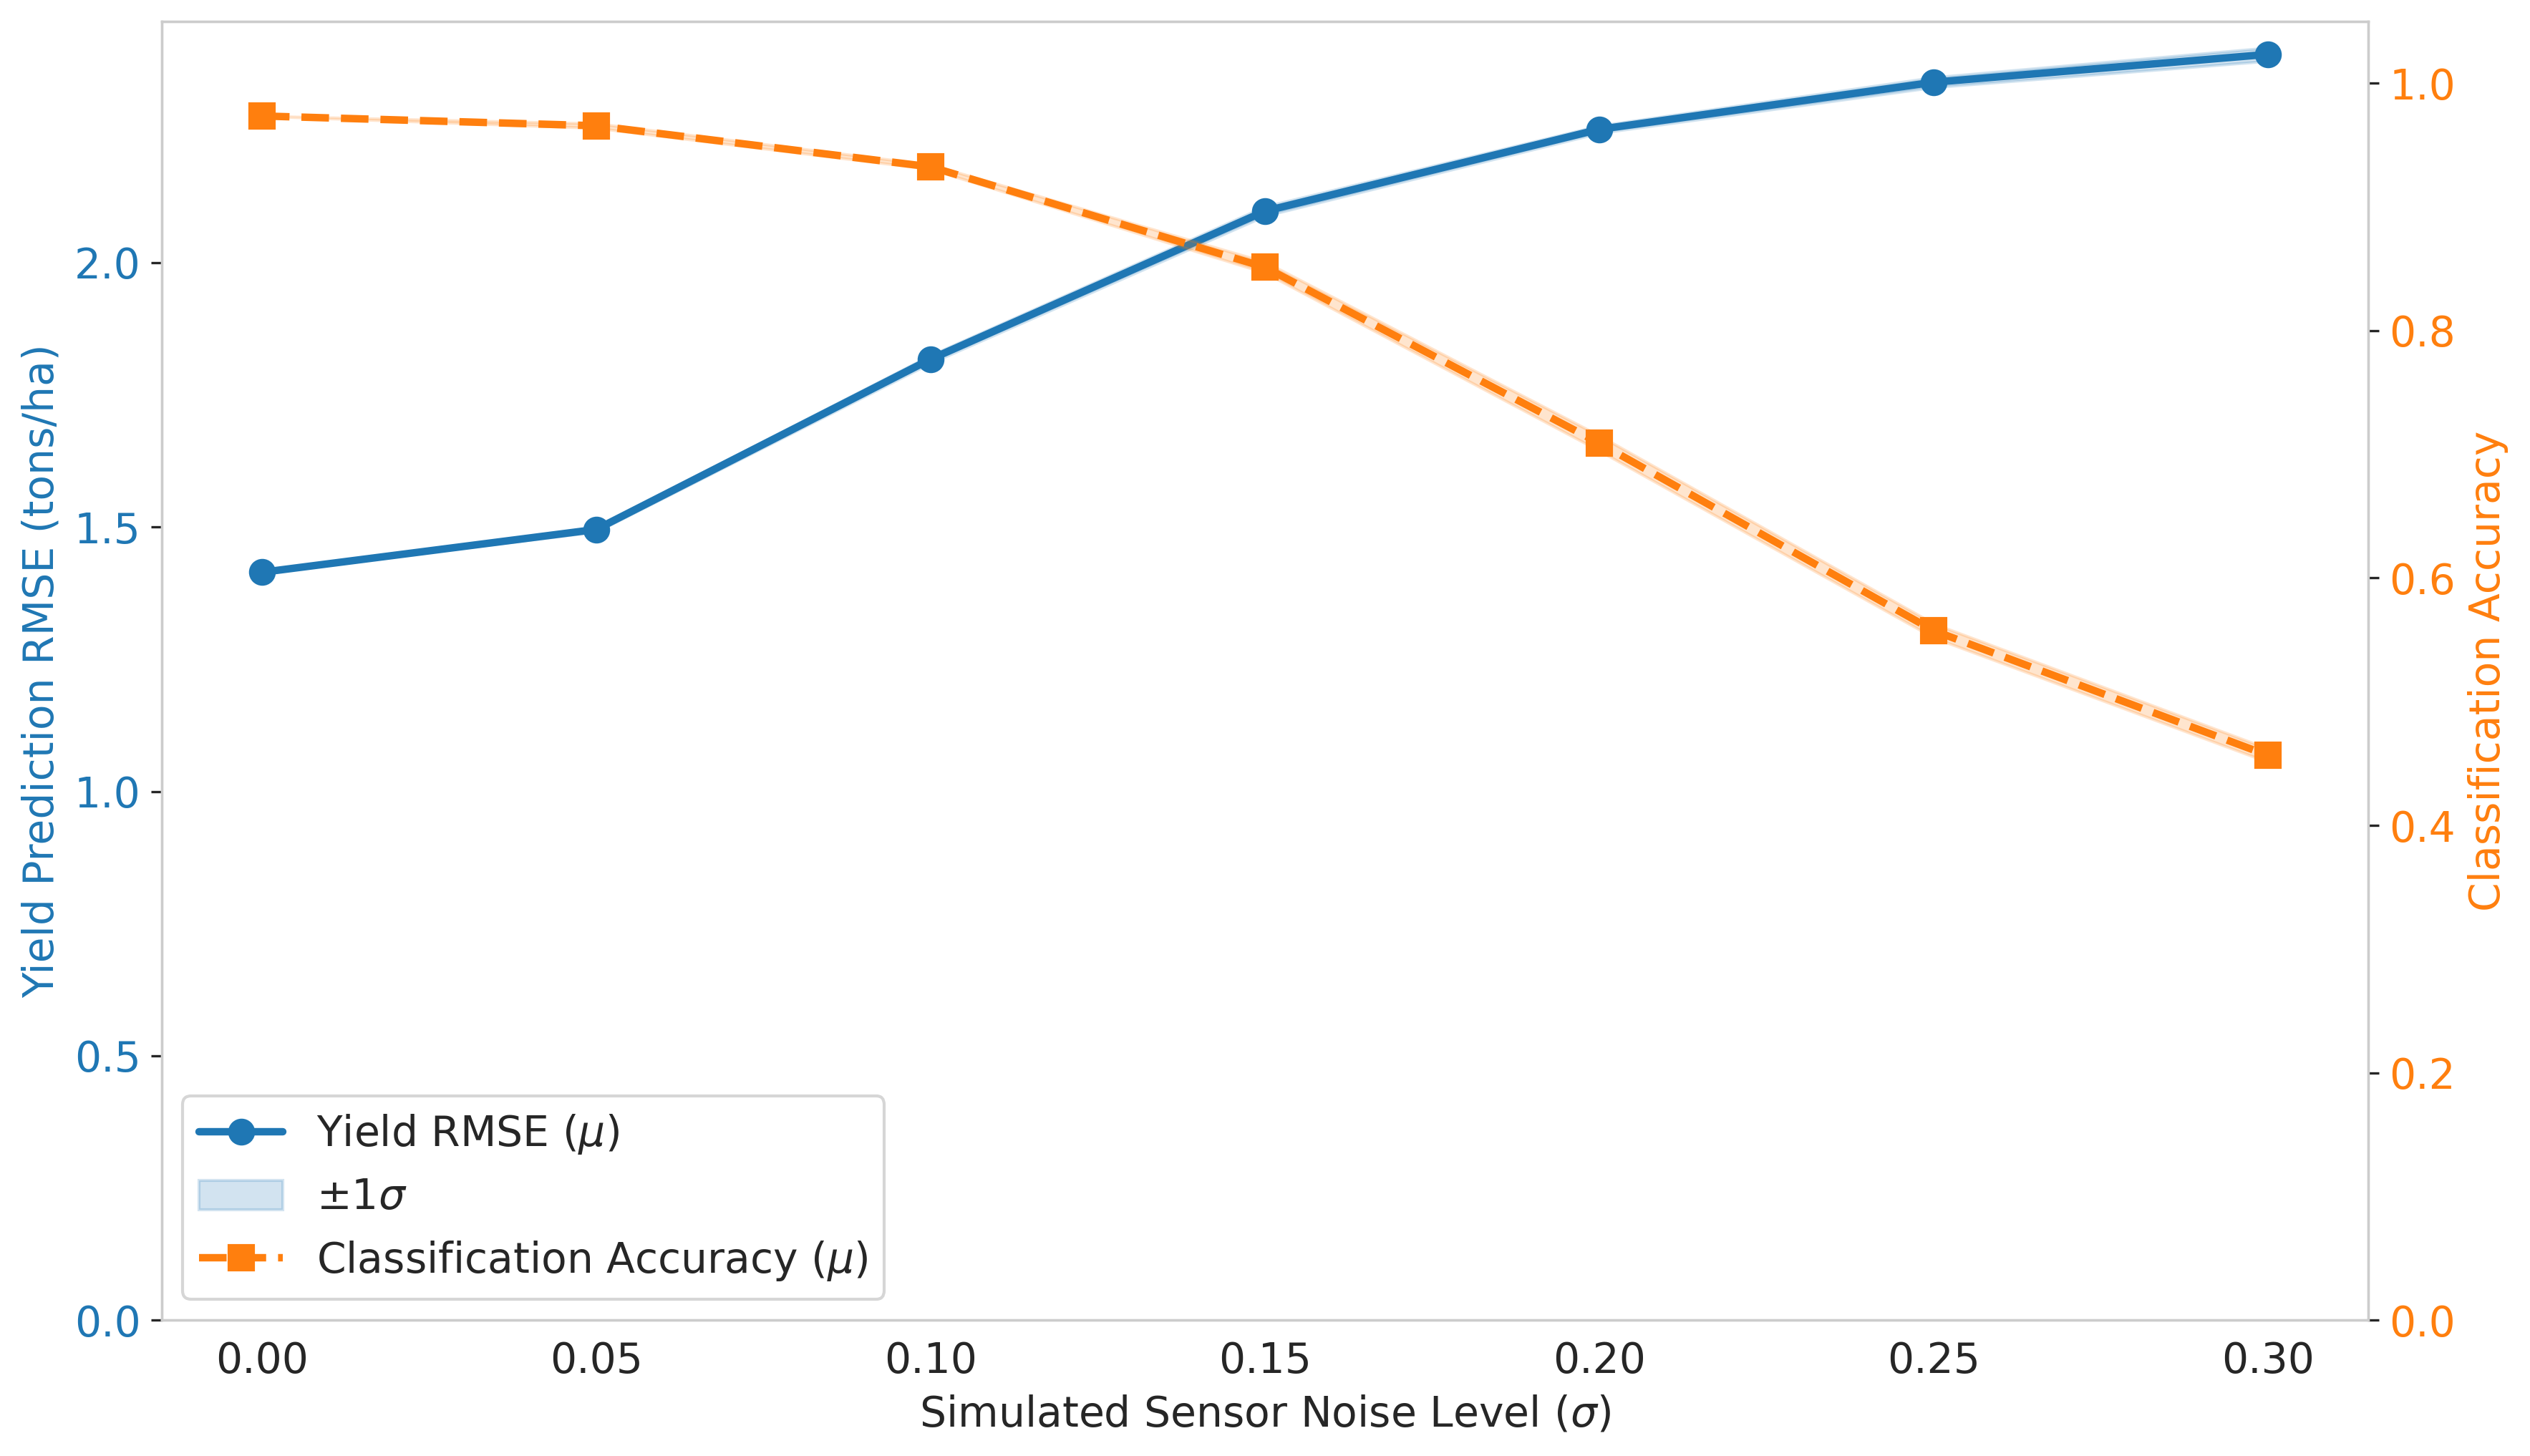


*** Log: Noise Sensitivity Data Table ***
 sigma  mean_rmse  std_rmse  mean_accuracy  std_accuracy
  0.00   1.414344  0.000000       0.973598      0.000000
  0.05   1.495481  0.004444       0.965703      0.001810
  0.10   1.817515  0.007257       0.932462      0.001764
  0.15   2.097411  0.008811       0.851245      0.004393
  0.20   2.252183  0.006849       0.709002      0.006094
  0.25   2.341170  0.009340       0.557430      0.005643
  0.30   2.393996  0.012513       0.456575      0.005411
------------------------------------------------------------


In [10]:
# CELL 10
# ==============================================================================
# ANALYSIS: Noise Sensitivity & System Robustness (Sigma 0.0 to 0.3)
# ==============================================================================
import copy
import pandas as pd
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- FORCE RESET SEED (Hardcoded 26 for absolute safety) ---
set_seed(26)

# --- Configuration for the Analysis ---
NOISE_LEVELS = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
N_REPEATS = 10
noise_analysis_results = []

# --- Identify the raw sensor columns ---
raw_sensor_cols = ['temp', 'humidity', 'soil_moisture'] + [f'qdss_{i}' for i in range(CONFIG.QDSS_FEATURES)]

print("Initiating Noise Sensitivity & Robustness Analysis (σ=[0.05-0.30])...")

# --- STEP 1: Baseline (Sigma=0) ---
global_model.eval()
with torch.no_grad():
    pred_yield_clean, pred_stress_clean = global_model(X_test_tensor)

baseline_rmse = np.sqrt(mean_squared_error(y_yield_test_np, pred_yield_clean.cpu().numpy()))
baseline_accuracy = accuracy_score(y_stress_test_np, pred_stress_clean.argmax(dim=1).cpu().numpy())

noise_analysis_results.append({
    'sigma': 0.0,
    'mean_rmse': baseline_rmse, 'std_rmse': 0.0,
    'mean_accuracy': baseline_accuracy, 'std_accuracy': 0.0
})
print(f"  Completed analysis for sigma = 0.00 (Baseline)")

# --- STEP 2: Noise Loop ---
for sigma in tqdm(NOISE_LEVELS, desc="Noise Analysis Progress"):
    temp_rmse_scores, temp_accuracy_scores = [], []
    for i in range(N_REPEATS):
        test_data_noisy_raw = copy.deepcopy(test_data)
        for col in raw_sensor_cols:
            noise = np.random.normal(0, sigma, size=test_data_noisy_raw.shape[0])
            test_data_noisy_raw[col] += noise

        test_data_noisy_featured = engineer_features(test_data_noisy_raw)
        X_test_noisy_np = test_data_noisy_featured[feature_cols].values
        X_test_noisy_scaled_np = scaler.transform(X_test_noisy_np)
        X_test_noisy_tensor = torch.tensor(X_test_noisy_scaled_np, dtype=torch.float32).to(device)

        y_yield_test_noisy_np = test_data_noisy_featured['yield'].values
        y_stress_test_noisy_np = test_data_noisy_featured['stress_type'].values

        global_model.eval()
        with torch.no_grad():
            pred_yield_noisy, pred_stress_noisy = global_model(X_test_noisy_tensor)

        rmse = np.sqrt(mean_squared_error(y_yield_test_noisy_np, pred_yield_noisy.cpu().numpy()))
        accuracy = accuracy_score(y_stress_test_noisy_np, pred_stress_noisy.argmax(dim=1).cpu().numpy())
        temp_rmse_scores.append(rmse)
        temp_accuracy_scores.append(accuracy)

    noise_analysis_results.append({
        'sigma': sigma,
        'mean_rmse': np.mean(temp_rmse_scores), 'std_rmse': np.std(temp_rmse_scores),
        'mean_accuracy': np.mean(temp_accuracy_scores), 'std_accuracy': np.std(temp_accuracy_scores)
    })

# --- Convert results to a DataFrame ---
results_df = pd.DataFrame(noise_analysis_results).sort_values(by='sigma').reset_index(drop=True)

print("\nAnalysis complete. Generating final plot...")

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(12, 7))
color_rmse = 'tab:blue'
ax1.plot(results_df['sigma'], results_df['mean_rmse'], 'o-', color=color_rmse, label=r'Yield RMSE ($\mu$)', linewidth=2.5)
ax1.fill_between(results_df['sigma'],
                 results_df['mean_rmse'] - results_df['std_rmse'],
                 results_df['mean_rmse'] + results_df['std_rmse'],
                 color=color_rmse, alpha=0.2, label=r'$\pm 1 \sigma$')
ax1.set_xlabel(r'Simulated Sensor Noise Level ($\sigma$)', fontsize=14)
ax1.set_ylabel('Yield Prediction RMSE (tons/ha)', color=color_rmse, fontsize=14)
ax1.tick_params(axis='y', labelcolor=color_rmse)
ax1.set_ylim(bottom=0)

ax2 = ax1.twinx()
color_acc = 'tab:orange'
ax2.plot(results_df['sigma'], results_df['mean_accuracy'], 's--', color=color_acc, label=r'Classification Accuracy ($\mu$)', linewidth=2.5)
ax2.fill_between(results_df['sigma'],
                 results_df['mean_accuracy'] - results_df['std_accuracy'],
                 results_df['mean_accuracy'] + results_df['std_accuracy'],
                 color=color_acc, alpha=0.2)
ax2.set_ylabel('Classification Accuracy', color=color_acc, fontsize=14)
ax2.tick_params(axis='y', labelcolor=color_acc)
ax2.set_ylim(0, 1.05)

# Legend Combination
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='lower left', frameon=True)

ax1.grid(False)
ax2.grid(False)
fig.tight_layout()
plt.savefig(os.path.join(output_folder, "noise_sensitivity_analysis_with_baseline.png"))
plt.show()

# TEXT DUMP
print("\n*** Log: Noise Sensitivity Data Table ***")
print(results_df.to_string(index=False))
print("-" * 60)

### **CELL 11: Security Analysis**

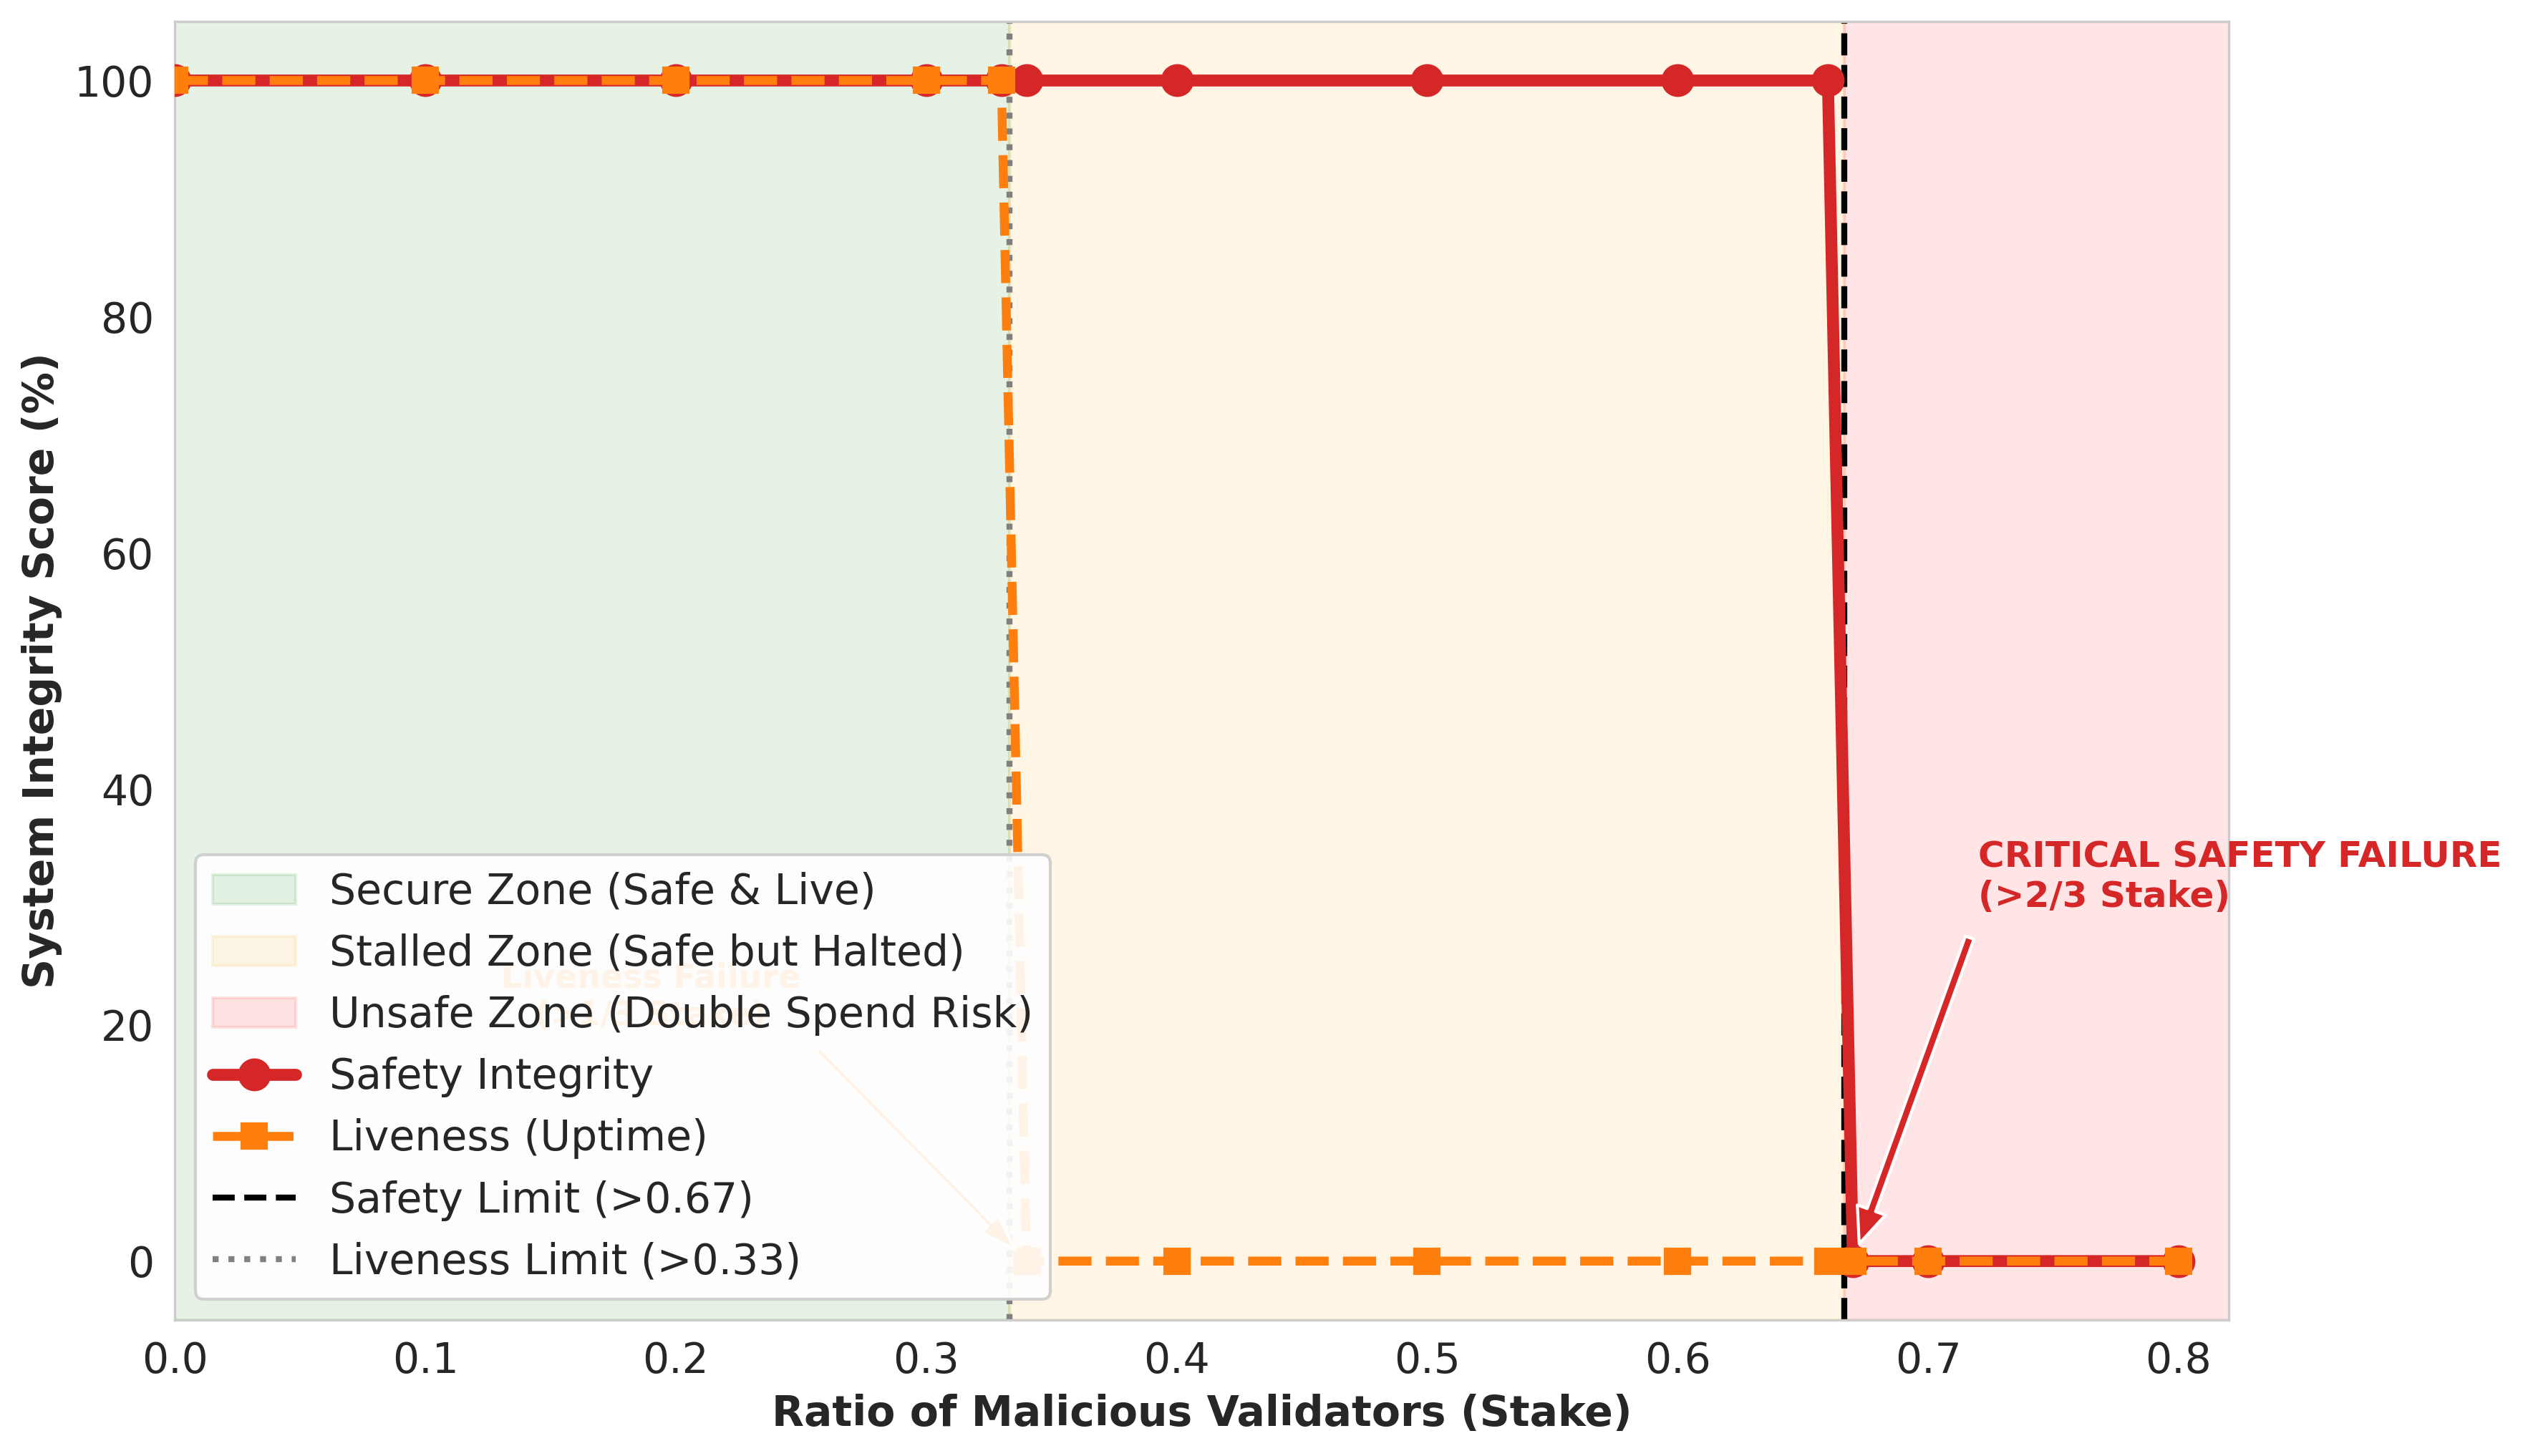


*** Log: Security Stress Test Data ***
 Malicious_Stake  Safety  Liveness
            0.00   100.0     100.0
            0.10   100.0     100.0
            0.20   100.0     100.0
            0.30   100.0     100.0
            0.33   100.0     100.0
            0.34   100.0       0.0
            0.40   100.0       0.0
            0.50   100.0       0.0
            0.60   100.0       0.0
            0.66   100.0       0.0
            0.67     0.0       0.0
            0.70     0.0       0.0
            0.80     0.0       0.0
------------------------------------------------------------

*** Log: Threat Matrix & Mitigation Strategy ***
          Attack Likelihood   Impact                          Defense
    Sybil Attack     Medium     High    Identity verification + Stake
      51% Attack        Low Critical Slashing mechanism > Attack cost
Oracle Collusion     Medium     High        Decentralized Aggregation
 Sensor Spoofing       High   Medium           Hardware ECDSA Signing
---------

In [11]:
# CELL 11
# ==============================================================================
# ANALYSIS: Consensus Mechanism Security & Threat Matrix
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import os

# --- Define Constants Locally ---
SAFETY_THRESHOLD = 2/3  # > 2/3 malicious stake breaks SAFETY (invalid blocks finalized)
LIVENESS_THRESHOLD = 1/3 # > 1/3 malicious stake breaks LIVENESS (chain halts)

# 2. SECURITY STRESS TEST
malicious_ratios = [0.0, 0.1, 0.2, 0.3, 0.33, 0.34, 0.4, 0.5, 0.6, 0.66, 0.67, 0.7, 0.8]

safety_scores = []
liveness_scores = []

for ratio in malicious_ratios:
    # Safety is broken only if malicious actors control > 2/3
    safety_broken = ratio > SAFETY_THRESHOLD
    safety_scores.append(0.0 if safety_broken else 100.0)

    # Liveness is broken if malicious actors control > 1/3 (they can stall consensus)
    liveness_broken = ratio > LIVENESS_THRESHOLD
    liveness_scores.append(0.0 if liveness_broken else 100.0)

plt.figure(figsize=(12, 7))

# --- Highlight Zones ---
plt.axvspan(0, LIVENESS_THRESHOLD, color='green', alpha=0.1, label='Secure Zone (Safe & Live)')
plt.axvspan(LIVENESS_THRESHOLD, SAFETY_THRESHOLD, color='orange', alpha=0.1, label='Stalled Zone (Safe but Halted)')
plt.axvspan(SAFETY_THRESHOLD, max(malicious_ratios)+0.05, color='red', alpha=0.1, label='Unsafe Zone (Double Spend Risk)')

# --- Main Plots ---
plt.plot(malicious_ratios, safety_scores, marker='o', color='#d62728', linewidth=4, markersize=10, label='Safety Integrity', zorder=3)
plt.plot(malicious_ratios, liveness_scores, marker='s', color='#ff7f0e', linewidth=3, markersize=8, linestyle='--', label='Liveness (Uptime)', zorder=3)

plt.axvline(x=SAFETY_THRESHOLD, color='black', linestyle='--', linewidth=2, label=f'Safety Limit (>{SAFETY_THRESHOLD:.2f})', zorder=2)
plt.axvline(x=LIVENESS_THRESHOLD, color='gray', linestyle=':', linewidth=2, label=f'Liveness Limit (>{LIVENESS_THRESHOLD:.2f})', zorder=2)

# --- Annotations ---
idx_liveness_fail = malicious_ratios.index(0.34)
plt.annotate(f'Liveness Failure\n(>1/3 Stake)',
             xy=(malicious_ratios[idx_liveness_fail], liveness_scores[idx_liveness_fail]),
             xytext=(malicious_ratios[idx_liveness_fail]-0.15, 20),
             arrowprops=dict(facecolor='#ff7f0e', shrink=0.05, width=2, headwidth=8),
             fontsize=11, fontweight='bold', color='#ff7f0e', ha='center')

idx_safety_fail = malicious_ratios.index(0.67)
plt.annotate(f'CRITICAL SAFETY FAILURE\n(>2/3 Stake)',
             xy=(malicious_ratios[idx_safety_fail], safety_scores[idx_safety_fail]),
             xytext=(malicious_ratios[idx_safety_fail]+0.05, 30),
             arrowprops=dict(facecolor='#d62728', shrink=0.05, width=3, headwidth=10),
             fontsize=12, fontweight='bold', color='#d62728')

plt.xlabel('Ratio of Malicious Validators (Stake)', fontsize=14, fontweight='bold')
plt.ylabel('System Integrity Score (%)', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', frameon=True, fancybox=True, framealpha=0.9)
plt.grid(False)
plt.xlim(0, max(malicious_ratios)+0.02)
plt.ylim(-5, 105)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "security_stress_test_highlighted.png"))
plt.show()

# TEXT DUMP
print("\n*** Log: Security Stress Test Data ***")
print(pd.DataFrame({'Malicious_Stake': malicious_ratios, 'Safety': safety_scores, 'Liveness': liveness_scores}).to_string(index=False))
print("-" * 60)

# 3. THREAT MATRIX
print("\n*** Log: Threat Matrix & Mitigation Strategy ***")
threats = [
    ["Sybil Attack", "Medium", "High", "Identity verification + Stake"],
    ["51% Attack", "Low", "Critical", "Slashing mechanism > Attack cost"],
    ["Oracle Collusion", "Medium", "High", "Decentralized Aggregation"],
    ["Sensor Spoofing", "High", "Medium", "Hardware ECDSA Signing"]
]
print(pd.DataFrame(threats, columns=["Attack", "Likelihood", "Impact", "Defense"]).to_string(index=False))
print("-" * 60)

### **CELL 12: Packaging & Download**

In [12]:
# CELL 12
# ==============================================================================
# FINALIZATION: Archive Results for Submission
# Packages figures, logs, and model artifacts into a ZIP file.
# ==============================================================================
import os
import shutil

print("📦 Packaging Final Submission Artifacts...")

# Ensure folder exists (redundant check but safe)
os.makedirs(output_folder, exist_ok=True)

# Create zip archive of the output folder (contains PNGs, Model .pth, Scaler .pkl)
shutil.make_archive("QAL_Data_Artifacts", 'zip', output_folder)

print(f"✅ Submission Package Created: QAL_Data_Artifacts.zip")
print(f"   Contents: High-Res Plots, Model Weights (qal_fspm_model.pth), Scaler (feature_scaler.pkl)")

📦 Packaging Final Submission Artifacts...
✅ Submission Package Created: QAL_Data_Artifacts.zip
   Contents: High-Res Plots, Model Weights (qal_fspm_model.pth), Scaler (feature_scaler.pkl)
